# Import packages and set seed for reproducibility

In [1]:
import sys
#!conda install --yes --prefix {sys.prefix} python-dotenv
#!conda install --yes --prefix {sys.prefix} pydot
#!conda install --yes --prefix {sys.prefix} librosa
#!pip install audiomentations

In [2]:
import os
import time
import json
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, normalize

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

import librosa
import librosa.display
import IPython.display as ipd

import audiomentations as audio

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def set_seed(seed, use_gpu = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        print("CUDA is available")
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 12345
USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

CUDA is available


# Create small subset metadata

In [4]:
AUDIO_DIR = "./data/fma_small/"

In [5]:
# load metadata
tracks = utils.load('data/fma_metadata/tracks.csv')

In [6]:
# inspect metadata columns
assert tracks.columns.nlevels == 2

format_spec = "{:<15} {:<120}"
print(format_spec.format("first level:", "second level:"), "\n")

for first_level in tracks.columns.get_level_values(0).unique():
    second_level = tracks[first_level].columns
    second_level = ', '.join(second_level)
    print(format_spec.format(first_level, second_level))

first level:    second level:                                                                                                            

album           comments, date_created, date_released, engineer, favorites, id, information, listens, producer, tags, title, tracks, type
artist          active_year_begin, active_year_end, associated_labels, bio, comments, date_created, favorites, id, latitude, location, longitude, members, name, related_projects, tags, website, wikipedia_page
set             split, subset                                                                                                           
track           bit_rate, comments, composer, date_created, date_recorded, duration, favorites, genre_top, genres, genres_all, information, interest, language_code, license, listens, lyricist, number, publisher, tags, title


In [7]:
# select small subset
small_subset = tracks[tracks['set', 'subset'] <= 'small']
assert small_subset.shape[0] == 8000

In [8]:
# create metadata
classes = small_subset.loc[:,('track', 'genre_top')]
metadata_df = pd.DataFrame({
    'track_id' : classes.index.tolist(),
    'genre' : classes.values.tolist()
})

metadata_df

track_id    genre
0            2  Hip-Hop
1            5  Hip-Hop
2           10      Pop
3          140     Folk
4          141     Folk
...        ...      ...
7995    154308  Hip-Hop
7996    154309  Hip-Hop
7997    154413      Pop
7998    154414      Pop
7999    155066  Hip-Hop

[8000 rows x 2 columns]

# Data cleaning

## Check integrity of audio tracks

In [9]:
corrupted_tracks = [99134, 108925, 133297]
metadata_df = metadata_df[~metadata_df['track_id'].isin(corrupted_tracks)].reset_index(drop=True)
metadata_df

track_id    genre
0            2  Hip-Hop
1            5  Hip-Hop
2           10      Pop
3          140     Folk
4          141     Folk
...        ...      ...
7992    154308  Hip-Hop
7993    154309  Hip-Hop
7994    154413      Pop
7995    154414      Pop
7996    155066  Hip-Hop

[7997 rows x 2 columns]

## Check sampling rates and durations of audio tracks

In [10]:
AUDIO_INFO = False

In [11]:
def get_audio_info(track_id):

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        audio_path = utils.get_audio_path(AUDIO_DIR, track_id)
        y, sr = librosa.load(audio_path, sr=None, mono=True)

        return (track_id, sr, y.shape[0]/sr)

if AUDIO_INFO:
    audio_info = process_map(get_audio_info, metadata_df['track_id'][:10], max_workers=os.cpu_count(), chunksize=1)
    audio_info_df = pd.DataFrame(audio_info, columns=['track_id', 'sampling_rate', 'duration'])
    audio_info_df.to_csv('./cleaning/audio_info.csv', index=False)

In [12]:
audio_info_df = pd.read_csv('./cleaning/audio_info.csv')
audio_info_df

track_id  sampling_rate   duration
0            2          44100  29.976576
1            5          44100  30.002698
2           10          44100  29.976576
3          140          44100  29.976576
4          141          44100  29.976576
...        ...            ...        ...
7992    154308          44100  29.976576
7993    154309          44100  29.976576
7994    154413          44100  30.002698
7995    154414          44100  29.976576
7996    155066          44100  29.976576

[7997 rows x 3 columns]

Check if each audio track is long enough to gurantee 512 time bins in the spectrogram, given a hop length of 1024 and a window length of 4096 (centered and padded).

In [13]:
mask = audio_info_df.apply(lambda row: False if row['duration']*row['sampling_rate']/1024 + 1 < 512 else True, axis=1)
tracks_to_discard = audio_info_df[~mask]['track_id'].to_list()
print(tracks_to_discard)

[98565, 98567, 98569]


In [14]:
metadata_df = metadata_df[~metadata_df['track_id'].isin(tracks_to_discard)].reset_index(drop=True)
metadata_df

track_id    genre
0            2  Hip-Hop
1            5  Hip-Hop
2           10      Pop
3          140     Folk
4          141     Folk
...        ...      ...
7989    154308  Hip-Hop
7990    154309  Hip-Hop
7991    154413      Pop
7992    154414      Pop
7993    155066  Hip-Hop

[7994 rows x 2 columns]

# Split into train, valid and test paths

In [15]:
# shuffle data
metadata_df_shuffled = metadata_df.sample(frac = 1, random_state = 0).reset_index(drop=True)

# split train, valid and test data
train_df, valid_df, test_df = np.split(metadata_df_shuffled, [int(0.8*len(metadata_df_shuffled)), int(0.9*len(metadata_df_shuffled))])
print("train:", len(train_df))
print("valid:", len(valid_df))
print("test:", len(test_df))

train: 6395
valid: 799
test: 800


# Data augmentation

In [16]:
train_audio_transform = audio.Compose([   
    # add gaussian noise to the samples
    audio.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    # change the speed or duration of the signal without changing the pitch
    audio.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # pitch shift the sound up or down without changing the tempo
    #audio.PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])

valid_audio_transform = audio.Compose([
])

test_audio_transform = audio.Compose([
])

# Data normalization

In [17]:
NORM = False

## Audio

In [18]:
def audio_mean(track_id):
    audio_path = utils.get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    mean = np.sum(y)/y.shape[0]
    return mean

if NORM:
    train_audio_means = process_map(audio_mean, train_df['track_id'], max_workers=os.cpu_count(), chunksize=1)
    train_audio_mean = np.array(train_audio_means).mean()
    np.save('./normalization/train_audio_mean.npy', train_audio_mean)

In [19]:
train_audio_mean = np.load('./normalization/train_audio_mean.npy')
print(train_audio_mean)

-0.0004315782934168924


In [20]:
def audio_var(track_id):
    audio_path = utils.get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    var = np.sum((y - train_audio_mean)**2)/(y.shape[0] - 1)
    return var

if NORM:
    train_audio_vars = process_map(audio_var, train_df['track_id'], max_workers=os.cpu_count(), chunksize=1)
    train_audio_var = np.array(train_audio_vars).mean()
    train_audio_std = np.sqrt(train_audio_var)
    np.save('./normalization/train_audio_std.npy', train_audio_std)

In [21]:
train_audio_std = np.load('./normalization/train_audio_std.npy')
print(train_audio_std)

0.2156333329980191


In [22]:
def normalize_audio(y, mean, std):
    # z-score normalization
    y = (y - mean)/std
    return y

train_audio_normalize = transforms.Compose([
    transforms.Lambda(lambda y: normalize_audio(y, train_audio_mean, train_audio_std))
])

valid_audio_normalize = transforms.Compose([
    transforms.Lambda(lambda y: normalize_audio(y, train_audio_mean, train_audio_std))
])

test_audio_normalize = transforms.Compose([
    transforms.Lambda(lambda y: normalize_audio(y, train_audio_mean, train_audio_std))
])

## Spectrogram

In [23]:
def spectrogram_mean(track_id):
    audio_path = utils.get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=1024, n_mels=128)
    S = librosa.power_to_db(S, ref=np.max)
    mean = np.sum(S, axis=1)/(S.shape[1])
    return mean

if NORM:
    train_spectrogram_means = process_map(spectrogram_mean, train_df['track_id'], max_workers=os.cpu_count(), chunksize=1)
    train_spectrogram_mean = np.array(train_spectrogram_means).mean(axis=0)
    np.save('./normalization/train_spectrogram_mean.npy', train_spectrogram_mean)

In [24]:
train_spectrogram_mean = np.load('./normalization/train_spectrogram_mean.npy')
print(train_spectrogram_mean)

[-31.919003 -24.643408 -22.740467 -23.118484 -23.71736  -24.189228
 -24.77263  -25.527262 -26.37807  -27.082975 -28.017015 -28.705084
 -29.186264 -29.98158  -30.87946  -31.250374 -31.995142 -32.77024
 -32.638927 -33.85298  -33.532566 -34.007935 -35.3595   -35.75598
 -35.102688 -35.886482 -37.614937 -36.242752 -36.572823 -38.674564
 -37.989155 -37.419804 -38.005608 -38.611794 -39.32247  -39.487347
 -38.399086 -39.04115  -40.3687   -40.016075 -39.215725 -40.413837
 -41.09045  -40.761005 -40.773514 -40.562218 -41.05438  -41.700554
 -41.77202  -40.996105 -42.220783 -42.92152  -42.359905 -42.3202
 -42.99405  -43.402233 -43.31733  -43.701256 -43.207375 -44.07026
 -44.52934  -44.344112 -44.26497  -45.374012 -45.905884 -45.64169
 -46.223564 -46.264378 -46.748753 -47.04515  -47.31161  -47.31818
 -48.059547 -48.617867 -48.66128  -49.365543 -49.761944 -50.264874
 -50.645752 -51.142406 -51.364983 -51.98059  -52.516342 -52.69606
 -53.190624 -53.567825 -54.082134 -54.327473 -54.763252 -55.030403
 -5

In [25]:
def spectrogram_var(track_id):
    audio_path = utils.get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=1024, n_mels=128)
    S = librosa.power_to_db(S, ref=np.max)
    var = np.sum((S - train_spectrogram_mean[:,None])**2, axis=1)/(S.shape[1] - 1)
    return var

if NORM:
    train_spectrogram_vars = process_map(spectrogram_var, train_df['track_id'], max_workers=os.cpu_count(), chunksize=1)
    train_spectrogram_var = np.array(train_spectrogram_vars).mean(axis=0)
    train_spectrogram_std = np.sqrt(train_spectrogram_var)
    np.save('./normalization/train_spectrogram_std.npy', train_spectrogram_std)

In [26]:
train_spectrogram_std = np.load('./normalization/train_spectrogram_std.npy')
print(train_spectrogram_std)

[16.410961  15.759257  13.931824  12.705105  12.141258  11.705192
 11.507489  11.247475  11.055423  11.047739  11.194297  11.095331
 11.17149   11.464605  11.446615  11.770938  11.846549  11.555549
 12.002426  11.696415  12.274215  12.156729  12.162359  12.422486
 12.290764  12.144436  12.359309  12.344954  12.26211   12.51694
 12.185197  12.774072  12.192176  12.534443  12.452024  12.396199
 12.595998  12.312323  12.6754265 12.252549  12.745625  12.226473
 12.579354  12.498753  12.519339  12.633841  12.5006695 12.767969
 12.448273  12.793798  12.465751  12.736043  12.633497  12.757058
 12.830188  12.759375  12.991585  12.82215   13.027813  12.826251
 13.059559  12.98789   13.073528  13.121046  13.03539   13.081732
 12.979407  13.227316  13.115405  13.269173  13.260942  13.304173
 13.3402605 13.340105  13.404075  13.290575  13.368226  13.320939
 13.422814  13.448353  13.490575  13.532973  13.525045  13.579602
 13.5398245 13.580519  13.609074  13.631872  13.618733  13.649571
 13.669132 

In [27]:
def normalize_spectrogram(S, mean, std):
    
    mean = torch.from_numpy(mean[:,None])
    std = torch.from_numpy(std[:,None])
    
    # z-score normalization
    S = (S - mean)/std
    return S

train_spectrogram_normalize = transforms.Compose([
    transforms.Lambda(lambda S: normalize_spectrogram(S, train_spectrogram_mean, train_spectrogram_std))
])

valid_spectrogram_normalize = transforms.Compose([
    transforms.Lambda(lambda S: normalize_spectrogram(S, train_spectrogram_mean, train_spectrogram_std))
])

test_spectrogram_normalize = transforms.Compose([
    transforms.Lambda(lambda S: normalize_spectrogram(S, train_spectrogram_mean, train_spectrogram_std))
])

# Create a custom Dataset class

In [34]:
class AudioDataset(Dataset):

    def __init__(self, df, audio_transform=None, audio_normalize=None):
        # store track ids
        self.track_ids = df['track_id'].values
        # store genres using categorical encoding
        le = LabelEncoder() 
        self.genres = le.fit_transform(df['genre'])
        # create genre map
        self.genre_map = {categorical: genre for categorical, genre in enumerate(le.classes_)}
        # transformations
        self.audio_transform = audio_transform
        # normalization
        self.audio_normalize = audio_normalize


    def __len__(self):

        return len(self.track_ids)


    def get_index(self, track_id):
    
      return np.where(self.track_ids==track_id)[0][0]


    def plot_distribution(self):
        
        # get count by genre
        unique, counts = np.unique(self.genres, return_counts=True)

        plt.figure(figsize=(8,6))

        color_map = plt.get_cmap('Set2')

        plt.grid(ls="--", zorder=1)
        plt.bar(self.genre_map.values(), 100*counts/counts.sum(),
                color=color_map([i for i in range(8)]),
                path_effects=([pe.Stroke(linewidth=1, foreground='black')]),
                zorder=2)
        
        plt.xticks(fontsize=18, rotation=90)
        plt.yticks(fontsize=16)

        plt.ylim(0, 16)
        plt.ylabel('Genre population [%]', fontsize=18)

        plt.show()
 

    def load_audio(self, i):

        # get track id
        track_id = self.track_ids[i]

        # load audio track
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')

            audio_path = utils.get_audio_path(AUDIO_DIR, track_id)
            y, sr = librosa.load(audio_path, sr=None, mono=True)

            # select only 2**19 samples at random (behave like a audio.Shift transform)
            start = np.random.randint(0, y.shape[0]-2**19)
            y = y[start:start+2**19]

        return y, sr


    def play_audio(self, i):

        # load audio
        y, sr = self.load_audio(i)
        return ipd.Audio(data=y, rate=sr)   


    def plot_waveform(self, i):

        # get track id and genre (string)
        track_id = self.track_ids[i]
        genre = self.genre_map[self.genres[i]]

        y, sr = self.load_audio(i)
        
        

        fig, ax = plt.subplots(figsize=(10,6))
        librosa.display.waveshow(y, sr=sr, alpha=0.5, ax=ax, zorder=2)
        
        plt.ylim(-1,1)

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        plt.xlabel('Time [s]', fontsize=18)
        plt.ylabel('Amplitude', fontsize=18)
        plt.title(f'Audio waveform\ntrack id = {track_id} : genre = {genre}', fontsize=18)

        plt.grid(ls='--', zorder=1)
        
        #plt.savefig('./images/Waveform.pdf', dpi=1200, bbox_inches='tight')
        plt.show()


    def __getitem__(self, i):

        # load audio track
        y, sr = self.load_audio(i)

        # apply audio transformations
        if self.audio_transform:
            y = self.audio_transform(samples=y, sample_rate=sr)

        # add dummy channel dimension 
        y = y[None,:]

        # transform from numpy array to torch tensor
        y = torch.from_numpy(y)
        genre = torch.tensor(self.genres[i])
        
        # apply audio normalization
        if self.audio_normalize:
            y = self.audio_normalize(y)

        return y, genre

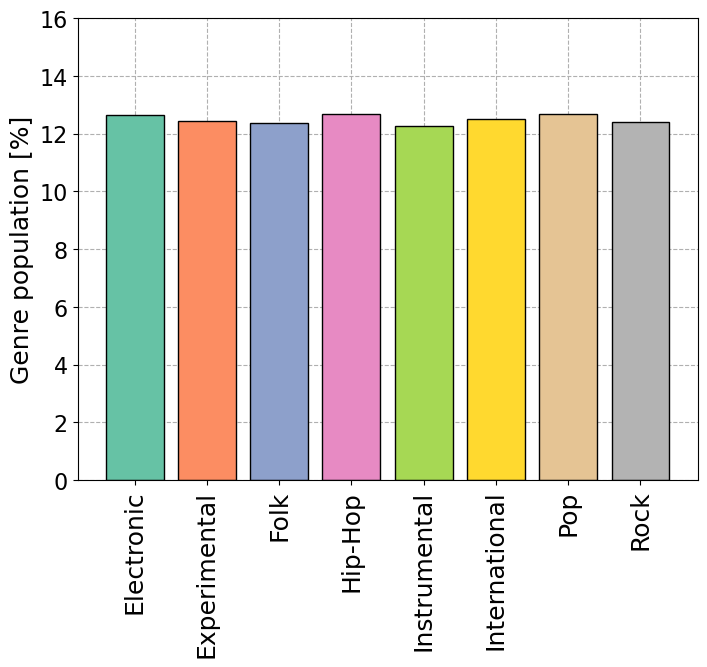

In [35]:
AudioDataset(train_df).plot_distribution()

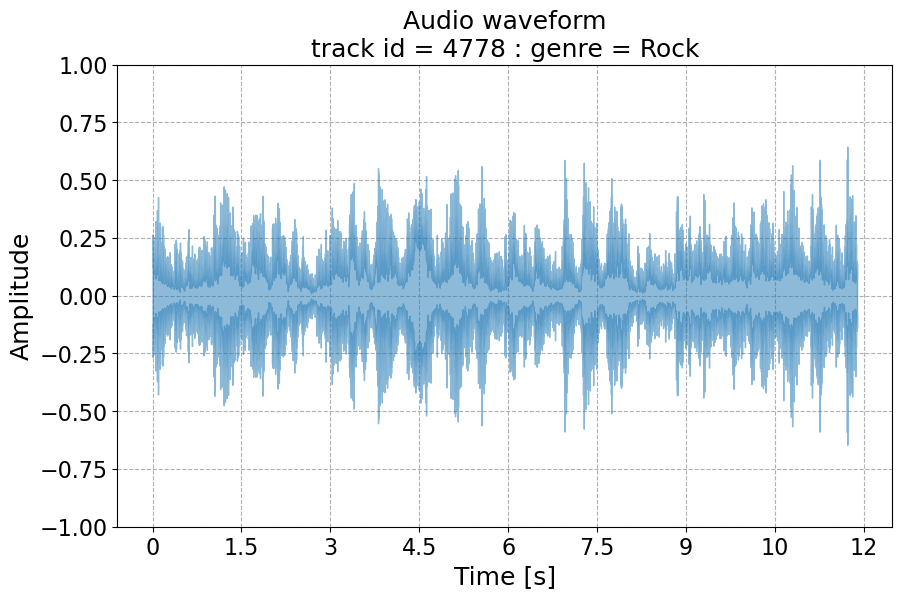

In [36]:
AudioDataset(train_df).plot_waveform(35)

In [37]:
class MelSpectrogramDataset(AudioDataset):

    def __init__(self, df, audio_transform=None, audio_normalize=None, spectrogram_normalize=None, double_output=False):
        super().__init__(df=df, audio_transform=audio_transform, audio_normalize=audio_normalize)
        # normalization
        self.spectrogram_normalize = spectrogram_normalize
        # double output
        self.double_output = double_output

    def create_mel_spectrogram(self, i):

        # get track id
        track_id = self.track_ids[i]

        # load audio
        y, sr = self.load_audio(i)

        # apply transformations
        if self.audio_transform:
            y = self.audio_transform(samples=y, sample_rate=sr)
                      
        # create lin-power mel spectrogram (discard last time bin)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=1024, n_mels=128)[:,:512]
        # create log-power mel spectrogram
        S = librosa.power_to_db(S, ref=np.max)

        return y, S, sr

    def plot_mel_spectrogram(self, i):

        # get track id and genre (string)
        track_id = self.track_ids[i]
        genre = self.genre_map[self.genres[i]]

        # get log-power mel spectrogram and sampling rate
        _, S, sr = self.create_mel_spectrogram(i)

        fig, ax = plt.subplots(figsize=(10,6))

        img = librosa.display.specshow(S, sr=sr, hop_length=1024, x_axis='time', y_axis='mel', ax=ax)

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        plt.xlabel('Time [s]', fontsize=18)
        plt.ylabel('Frequency [Hz]', fontsize=18)
        plt.title(f'Log-power mel-spectrogram\ntrack id = {track_id} : genre = {genre}', fontsize=20)

        cbar = plt.colorbar(img)
        cbar.ax.set_ylim(-80, 0)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label('dB', size=18)

        #plt.savefig('./images/Spectrogram.pdf', dpi=1200, bbox_inches='tight')
        plt.show()


    def __getitem__(self, i):

        # get audio, log-power mel spectrogram and sampling rate
        y, S, sr = self.create_mel_spectrogram(i)    

        # add dummy channel dimension and select only 512 time bins
        S = S[None,:,:]

        # transform from numpy array to torch tensor
        S = torch.from_numpy(S)
        genre = torch.tensor(self.genres[i])
        
        # apply spectrogram normalization
        if self.spectrogram_normalize:
            S = self.spectrogram_normalize(S)
            
        if self.double_output:
            
            # add dummy channel dimension
            y = y[None,:]
            
            # transform from numpy array to torch tensor
            y = torch.from_numpy(y)
            
            # apply audio normalization
            if self.audio_normalize:
                y = self.audio_normalize(y)
                
            return (y, S), genre
        else:
            return S, genre

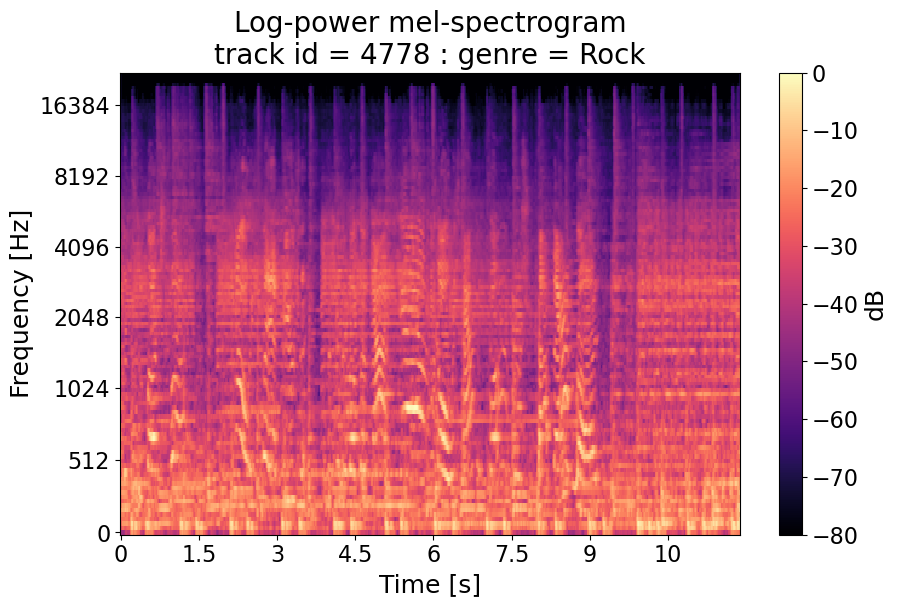

In [38]:
MelSpectrogramDataset(train_df).plot_mel_spectrogram(35)

# Get size of a waveform and a spectrogram

In [39]:
def sample_info(sample, names):

    format_spec = '{:<14} {:<26} {:<16} {:<16} {:<16}'
    print(format_spec.format('name:', 'object type:', 'data type:', 'shape:', 'size [Mb]:'), '\n')

    if len(names) == 3:
        elements = [sample[0][0], sample[0][1], sample[1]]
    else:
        elements = [sample[0], sample[1]]
        

    for name, el in zip(names, elements):
        print(format_spec.format(
            name,
            str(type(el)),
            str(el.dtype),
            str(list(el.shape)),
            str(round(sys.getsizeof(el.storage())/10**6, 2)))
        )

In [40]:
sample_info(AudioDataset(train_df)[0], names=['waveform', 'genre'])

name:          object type:               data type:       shape:           size [Mb]:       

waveform       <class 'torch.Tensor'>     torch.float32    [1, 524288]      2.1             
genre          <class 'torch.Tensor'>     torch.int64      []               0.0             


In [41]:
sample_info(MelSpectrogramDataset(train_df)[0], names=['spectrogram', 'genre'])

name:          object type:               data type:       shape:           size [Mb]:       

spectrogram    <class 'torch.Tensor'>     torch.float32    [1, 128, 512]    0.26            
genre          <class 'torch.Tensor'>     torch.int64      []               0.0             


In [42]:
sample_info(MelSpectrogramDataset(train_df, double_output=True)[0], names=['waveform', 'spectrogram', 'genre'])

name:          object type:               data type:       shape:           size [Mb]:       

waveform       <class 'torch.Tensor'>     torch.float32    [1, 524288]      2.1             
spectrogram    <class 'torch.Tensor'>     torch.float32    [1, 128, 512]    0.26            
genre          <class 'torch.Tensor'>     torch.int64      []               0.0             


# Define functions for training phase

In [43]:
def compute_CM_elements(y_logits, y):

    """
    Input
    ----------------------------------------------------
    y_logits: [BATCH_SIZE, N_CLASSES]
    y:        [BATCH_SIZE] (dense encoding)
    ----------------------------------------------------

    Temporary
    ------------------------------------------------------------------------
    y_prob:      [BATCH_SIZE, N_CLASSES]
    y_pred:      [BATCH_SIZE]
    y_pred_bool: [BATCH_SIZE, N_CLASSES] (one-hot encoding)
    y_bool:      [BATCH_SIZE, N_CLASSES] (one-hot encoding)
    ------------------------------------------------------------------------
    
    Output
    ---------------
    TP: [N_CLASSES]
    FP: [N_CLASSES]
    TN: [N_CLASSES]
    FN: [N_CLASSES]
    ---------------
    """

    y_prob = F.softmax(y_logits, dim=1)
    y_pred = y_prob.argmax(dim=1)

    y_pred_bool = F.one_hot(y_pred, num_classes=8).bool()
    y_bool = F.one_hot(y, num_classes=8).bool()

    # logical_and is element wise 'and', zeros element are always false
    # 0 == 0 -> False
    TP = torch.sum(torch.logical_and(y_pred_bool, y_bool), dim=0)
    FP = torch.sum(y_pred_bool, dim=0) - TP
    TN = torch.sum(torch.logical_and(~y_pred_bool, ~y_bool), dim=0)
    FN = torch.sum(~y_pred_bool, dim=0) - TN
    
    return TP, FP, TN, FN

In [44]:
def compute_metrics(loss, TP, FP, TN, FN):
    
    # loss
    loss = loss
    
    # accuracy and macro-averaging accuracy
    accuracy = (TP + TN)/(TP + FP + TN + FN)
    MA_accuracy = torch.sum(accuracy)/8
    
    # precision and macro-averaging precision
    precision = TP/(TP + FP)
    MA_precision = torch.sum(precision)/8
    
    # recall and macro-averaging recall
    recall = TP/(TP + FN)
    MA_recall = torch.sum(recall)/8
    
    # F1-score and macro-averaging F1-score
    F1_score = 2*(precision*recall)/(precision + recall)
    MA_F1_score = 2*(MA_precision*MA_recall)/(MA_precision + MA_recall)

    metrics = {
        'loss': loss.item(),
        'accuracy': accuracy.tolist(),
        'MA_accuracy': MA_accuracy.item(),
        'precision': precision.tolist(),
        'MA_precision': MA_precision.item(),
        'recall': recall.tolist(),
        'MA_recall': MA_recall.item(),
        'F1_score': F1_score.tolist(),
        'MA_F1_score': MA_F1_score.item()
    }
    
    return metrics

In [45]:
def train(model, iterator, criterion, optimizer, device, desc='Train'):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    # set train mode
    model.train()

    # loop over batches
    for x, y in tqdm(iterator, desc=desc): 

        # set gradients to zero
        optimizer.zero_grad()
        
        if type(x) is list:
            # move data to the GPU
            x[0] = x[0].to(device)
            x[1] = x[1].to(device)
            # make predictions
            y_logits = model(x[0], x[1])
        else:
            # move data to the GPU
            x = x.to(device)
            # make predictions
            y_logits = model(x)

        # move data to the GPU
        y = y.to(device)

        # compute loss
        loss = criterion(y_logits, y)

        # compute confusion matrix elements
        TP, FP, TN, FN = compute_CM_elements(y_logits, y)

        # compute gradients
        loss.backward()

        # update the weights according to the optimizer using the gradients
        optimizer.step()

        # update loss 
        epoch_loss += loss/len(iterator)

        # update confusion matrix elements
        epoch_TP += TP
        epoch_FP += FP
        epoch_TN += TN
        epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)
    
    return epoch_metrics

In [46]:
def evaluate(model, iterator, criterion, device, desc='Valid'):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

        # loop over batches
        for x, y in tqdm(iterator, desc=desc):
            
            if type(x) is list:
                # move data to the GPU
                x[0] = x[0].to(device)
                x[1] = x[1].to(device)
                # make predictions
                y_logits = model(x[0], x[1])
            else:
                # move data to the GPU
                x = x.to(device)
                # make predictions
                y_logits = model(x)

            # move data to the GPU
            y = y.to(device)

            # compute loss
            loss = criterion(y_logits, y)
            
            # compute confusion matrix elements
            TP, FP, TN, FN = compute_CM_elements(y_logits, y)

            # update loss 
            epoch_loss += loss/len(iterator)

            # update confusion matrix elements
            epoch_TP += TP
            epoch_FP += FP
            epoch_TN += TN
            epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics

In [47]:
def model_training(n_epochs, model, train_iterator, valid_iterator, criterion, optimizer, scheduler, device,
                   checkpoint_name='checkpoint.pt', results_name='results.csv'):

    # initialize validation loss
    best_valid_loss = float('inf')

    train_metrics_log = {}
    valid_metrics_log = {}

    print('----------------------------------------------------------')

    # loop over epochs
    for epoch in range(n_epochs):

        print(f'\nEpoch: {epoch + 1}/{n_epochs}\n')

        start_time = time.time()

        # training
        train_metrics = train(model, train_iterator, criterion, optimizer, device, desc='Train')

        # validation
        valid_metrics = evaluate(model, valid_iterator, criterion, device, desc='Valid')

        print(f"\nTrain:", \
              f"Loss = {train_metrics['loss']:.4f},", \
              f"MA_acc = {train_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {train_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {train_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {train_metrics['MA_F1_score']*100:.2f} %")
        
        print(f"Valid:", \
              f"Loss = {valid_metrics['loss']:.4f},", \
              f"MA_acc = {valid_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {valid_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {valid_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {valid_metrics['MA_F1_score']*100:.2f} %")

        # scheduler
        if scheduler:
            scheduler.step()

        end_time = time.time()

        print(f'\nEpoch Time: {end_time-start_time:.2f} s\n')
        print('----------------------------------------------------------')
        
        # model checkpoint
        if valid_metrics['loss'] < best_valid_loss:
            best_valid_loss = valid_metrics['loss']
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'criterion_state_dict': criterion.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if bool(scheduler) else None,
            }, os.path.join('./checkpoints', checkpoint_name))
        
        # save train metrics
        for key in train_metrics.keys():
            if key not in train_metrics_log:
                train_metrics_log[key] = []
            train_metrics_log[key].append(train_metrics[key])
            
        pd.DataFrame.from_dict(train_metrics_log).to_csv('./results/train_' + results_name, index=False)
        
        # save valid metrics
        for key in valid_metrics.keys():
            if key not in valid_metrics_log:
                valid_metrics_log[key] = []
            valid_metrics_log[key].append(valid_metrics[key])
            
        pd.DataFrame.from_dict(valid_metrics_log).to_csv('./results/valid_' + results_name, index=False)

    return train_metrics_log, valid_metrics_log

# Define functions to plot results

In [48]:
def plot_results(checkpoint_name='checkpoint.pt', results_name='results.csv'):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = 30#torch.load(os.path.join('./checkpoints', checkpoint_name))['epoch']
        train_results_df = pd.read_csv('./results/train_' + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv('./results/valid_' + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = 30#torch.load(os.path.join('./checkpoints', checkpoint_name[i]))['epoch']
            train_frames.append(pd.read_csv('train_' + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv('valid_' + results_name[i]).iloc[:best_epoch]) 
        train_results_df = pd.concat(train_frames, ignore_index=True)
        valid_results_df = pd.concat(valid_frames, ignore_index=True)
    
    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)
    
    plt.figure(figsize=(15,15))

    for i, metric in enumerate(['loss', 'MA_accuracy', 'MA_precision', 'MA_recall', 'MA_F1_score']):
    
        plt.subplot(3,2,i+1)

        plt.plot(np.arange(n_epochs)+1, train_results_df[metric], linewidth=3, color='tab:blue', label='Train')
        plt.plot(np.arange(n_epochs)+1, valid_results_df[metric], linewidth=3, color='tab:orange', label='Valid')

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        plt.xlabel('Epoch', fontsize=18)
        plt.ylabel(metric, fontsize=18)

        plt.legend(fontsize=16)
        plt.grid(ls='--')
    
    plt.show()

In [49]:
def plot_results_per_class(checkpoint_name='checkpoint.pt', results_name='results.csv'):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = 30#torch.load(os.path.join('./checkpoints', checkpoint_name))['epoch']
        train_results_df = pd.read_csv('./results/train_' + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv('./results/valid_' + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = 30#torch.load(os.path.join('./checkpoints', checkpoint_name[i]))['epoch']
            train_frames.append(pd.read_csv('train_' + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv('valid_' + results_name[i]).iloc[:best_epoch]) 
        train_results_df = pd.concat(train_frames, ignore_index=True)
        valid_results_df = pd.concat(valid_frames, ignore_index=True)
            
    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)
    
    plt.figure(figsize=(20,25))

    color_map = plt.get_cmap('Set2')
    genres = np.unique(train_df['genre'])
      
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'F1_score']):
        
        train_metric = np.zeros((n_epochs, 8))
        valid_metric = np.zeros((n_epochs, 8))
        
        for j in range(n_epochs):
            train_metric[j] = np.array(json.loads(train_results_df[metric].iloc[j].replace('nan', 'NaN')))
            valid_metric[j] = np.array(json.loads(valid_results_df[metric].iloc[j].replace('nan', 'NaN')))
 
        # train
        plt.subplot(4,2,2*i+1)

        for j in range(8):
            plt.plot(np.arange(n_epochs) + 1, train_metric[:,j], linewidth=3, color=color_map(j), label=genres[j],
                path_effects=([pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]))
            
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
                   
        plt.xlabel('Epoch', fontsize=18)
        plt.ylabel(metric + ' [Train]', fontsize=18)

        plt.subplots_adjust(right=0.8)
        plt.grid(ls='--')

        # valid
        plt.subplot(4,2,2*i+2)

        for j in range(8): 
            plt.plot(np.arange(n_epochs) + 1, valid_metric[:,j], linewidth=3, color=color_map(j), label=genres[j],
                path_effects=([pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]))
            
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
                   
        plt.xlabel('Epoch', fontsize=18)
        plt.ylabel(metric + ' [Valid]', fontsize=18)

        plt.subplots_adjust(right=0.8)
        plt.grid(ls='--')
        
        plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left', borderaxespad=0, fontsize=16)
    
    plt.show()

# Define functions for testing phase

In [50]:
def test(model, iterator, criterion, device, desc='Test'):

    loss = 0
    CM = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():
        
        # loop over batches
        for x, y in tqdm(iterator, desc=desc):
            
            if type(x) is list:
                # move data to the GPU
                x[0] = x[0].to(device)
                x[1] = x[1].to(device)
                # make predictions
                y_logits = model(x[0], x[1])
            else:
                # move data to the GPU
                x = x.to(device)
                # make predictions
                y_logits = model(x)

            # move data to the GPU
            y = y.to(device)

            # compute loss
            loss = criterion(y_logits, y)
            
            # get one hot prediction
            y_prob = F.softmax(y_logits, dim=1)
            y_pred = y_prob.argmax(dim=1)

            # update loss
            loss += loss/len(iterator)
            
            # update confusion matrix (CPU)
            CM += confusion_matrix(y.view(-1).tolist(), y_pred.view(-1).tolist(), labels=range(8))

    # move loss from GPU to CPU
    loss = loss.cpu()
    
    # compute TP, FP, TN, FN
    TP = CM.diagonal().copy()
    CM_no_diag = CM - np.diag(TP)
    FP = CM_no_diag.sum(axis=0)
    FN = CM_no_diag.sum(axis=1)
    TN = CM.sum() - (FP + FN + TP)
    
    # transfrom from numpy to tensor (CPU)
    TP = torch.from_numpy(TP)
    FP = torch.from_numpy(FP)
    TN = torch.from_numpy(TN)
    FN = torch.from_numpy(FN)

    metrics = compute_metrics(loss, TP, FP, TN, FN)

    return metrics, CM

In [51]:
def model_testing(model, test_iterator, criterion, device,
                  checkpoint_name='checkpoint.pt', results_name='results.csv', CM_name='confusion_matrix.csv'):
    
    # load checkpoint
    checkpoint = torch.load(os.path.join('./checkpoints', checkpoint_name))
    model.load_state_dict(checkpoint['model_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    
    metrics_log = {}

    # testing
    metrics, CM = test(model, test_iterator, criterion, device, desc='Test')
    
    # save metrics
    for key in metrics.keys():
        if key not in metrics_log:
            metrics_log[key] = []
        metrics_log[key].append(metrics[key])
        
    pd.DataFrame.from_dict(metrics_log).to_csv('./results/test_' + results_name, index=False)
    
    # save confusion matrix
    pd.DataFrame(CM).to_csv('./results/' + CM_name, index=False)

In [52]:
def plot_CM(CM_name='confusion_matrix.csv'):
    
    CM = pd.read_csv('./results/' + CM_name).values
    CM = normalize(CM, axis=1, norm='l1')
    
    fig, ax = plt.subplots(figsize=(9,7))
    ax = sn.heatmap(CM,
                    xticklabels=np.unique(train_df['genre']),
                    yticklabels=np.unique(train_df['genre']),
                    vmin=0, vmax=1,
                    cmap='Blues',
                    fmt='.2f',
                    ax=ax,
                    annot_kws={'fontsize': 16},
                    annot=True)

    ax.collections[0].colorbar.ax.tick_params(labelsize=16)
    plt.xticks(fontsize=18, rotation=90)
    plt.yticks(fontsize=18, rotation=0)
    plt.tight_layout()
    
    #plt.savefig('./images/CM.pdf', dpi=1200, bbox_inches='tight')
    plt.show()

# Baseline 1D: Convolutional Neural Network

## Define model

In [65]:
class Block1d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        return self.block(x)


class ConvBlock1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            Block1d(in_channels=1, out_channels=16, kernel_size=256, stride=64, padding=128),
            nn.MaxPool1d(kernel_size=4, stride=4),
            Block1d(in_channels=16, out_channels=32, kernel_size=32, stride=2, padding=16),
            nn.MaxPool1d(kernel_size=2, stride=2),
            Block1d(in_channels=32, out_channels=64, kernel_size=16, stride=2, padding=8),
            nn.MaxPool1d(kernel_size=2, stride=2),
            Block1d(in_channels=64, out_channels=128, kernel_size=8, stride=2, padding=4)
        )

    def forward(self, x):
        return self.block(x) # [128,1,65]

In [66]:
class Baseline1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = ConvBlock1d()
        self.avg_pool = nn.MaxPool1d(kernel_size=64)
        self.max_pool = nn.AvgPool1d(kernel_size=64)
        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(64,8)
        )
        
    def forward(self, x):
        x = self.conv_block(x) # [128, 64]
        x_avg = self.avg_pool(x) # [128, 1]
        x_max = self.max_pool(x) # [128, 1]
        x = torch.cat([x_avg, x_max], dim = 1) # [256, 1]
        return self.classifier(x.reshape((x.shape[0], -1)))

In [67]:
model = Baseline1d()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 161176


In [68]:
def receptive_field(n_layer, kernel_sizes, strides):

    # formula
    receptive_field = 0
    for l in range(n_layer):
        receptive_field += (kernel_sizes[l]-1)*np.prod(strides[:l])
    receptive_field += 1
    
    # to seconds
    receptive_field = receptive_field/44100
    
    print(f'Receptive field: {round(receptive_field, 2)} s')
    
receptive_field(7, np.array([256,4,32,2,16,2,8]), np.array([64,4,2,2,2,2,2]))

Receptive field: 1.25 s


## Create train, valid, and test datasets

In [69]:
train_dataset = AudioDataset(train_df, audio_transform=train_audio_transform, audio_normalize=train_audio_normalize)
valid_dataset = AudioDataset(valid_df, audio_transform=valid_audio_transform, audio_normalize=valid_audio_normalize)
test_dataset = AudioDataset(test_df, audio_transform=test_audio_transform, audio_normalize=test_audio_normalize)

## Create iterators over datasets

In [70]:
BATCH_SIZE = 32

# create iterators
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [71]:
#sample_info(next(iter(train_iterator)), names=['audio', 'genre'])

## Train model

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print('{} {} GPU available'.format(str(device_count), str(device_name)))

1 Tesla T4 GPU available


In [73]:
model = Baseline1d()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

scheduler = None

N_EPOCHS = 30

In [74]:
TRAIN = False

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          'checkpoint_baseline1d.pt',
                                                          'results_baseline1d.csv')

## Plot results

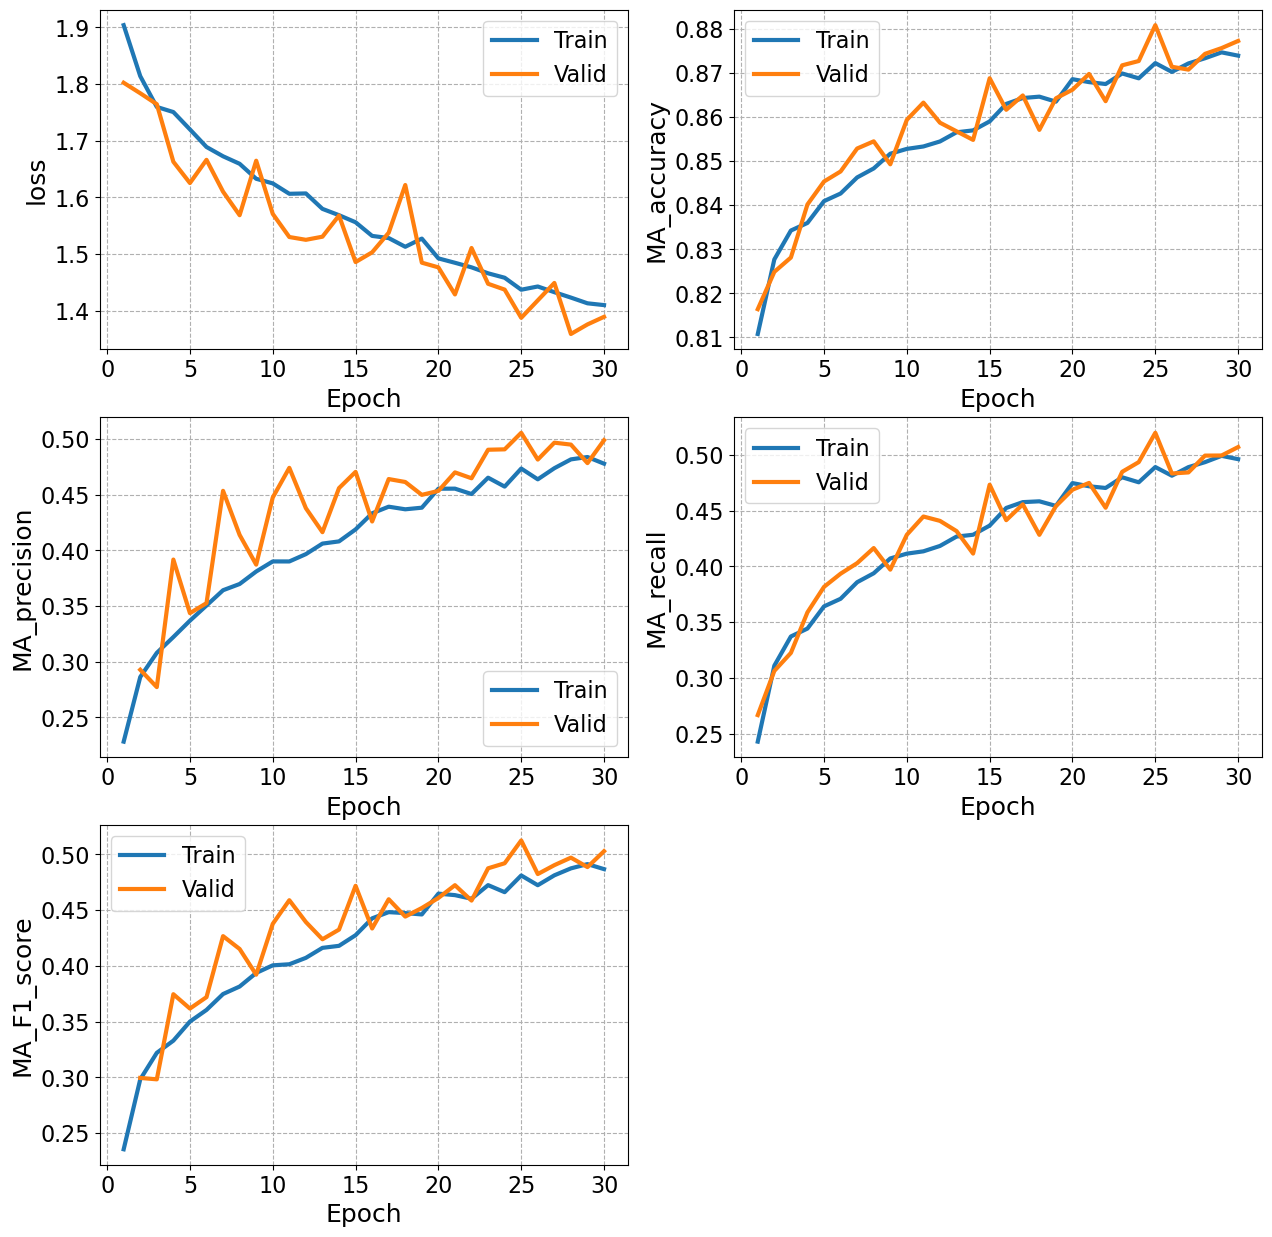

In [75]:
plot_results('checkpoint_baseline1d.pt', 'results_baseline1d.csv')

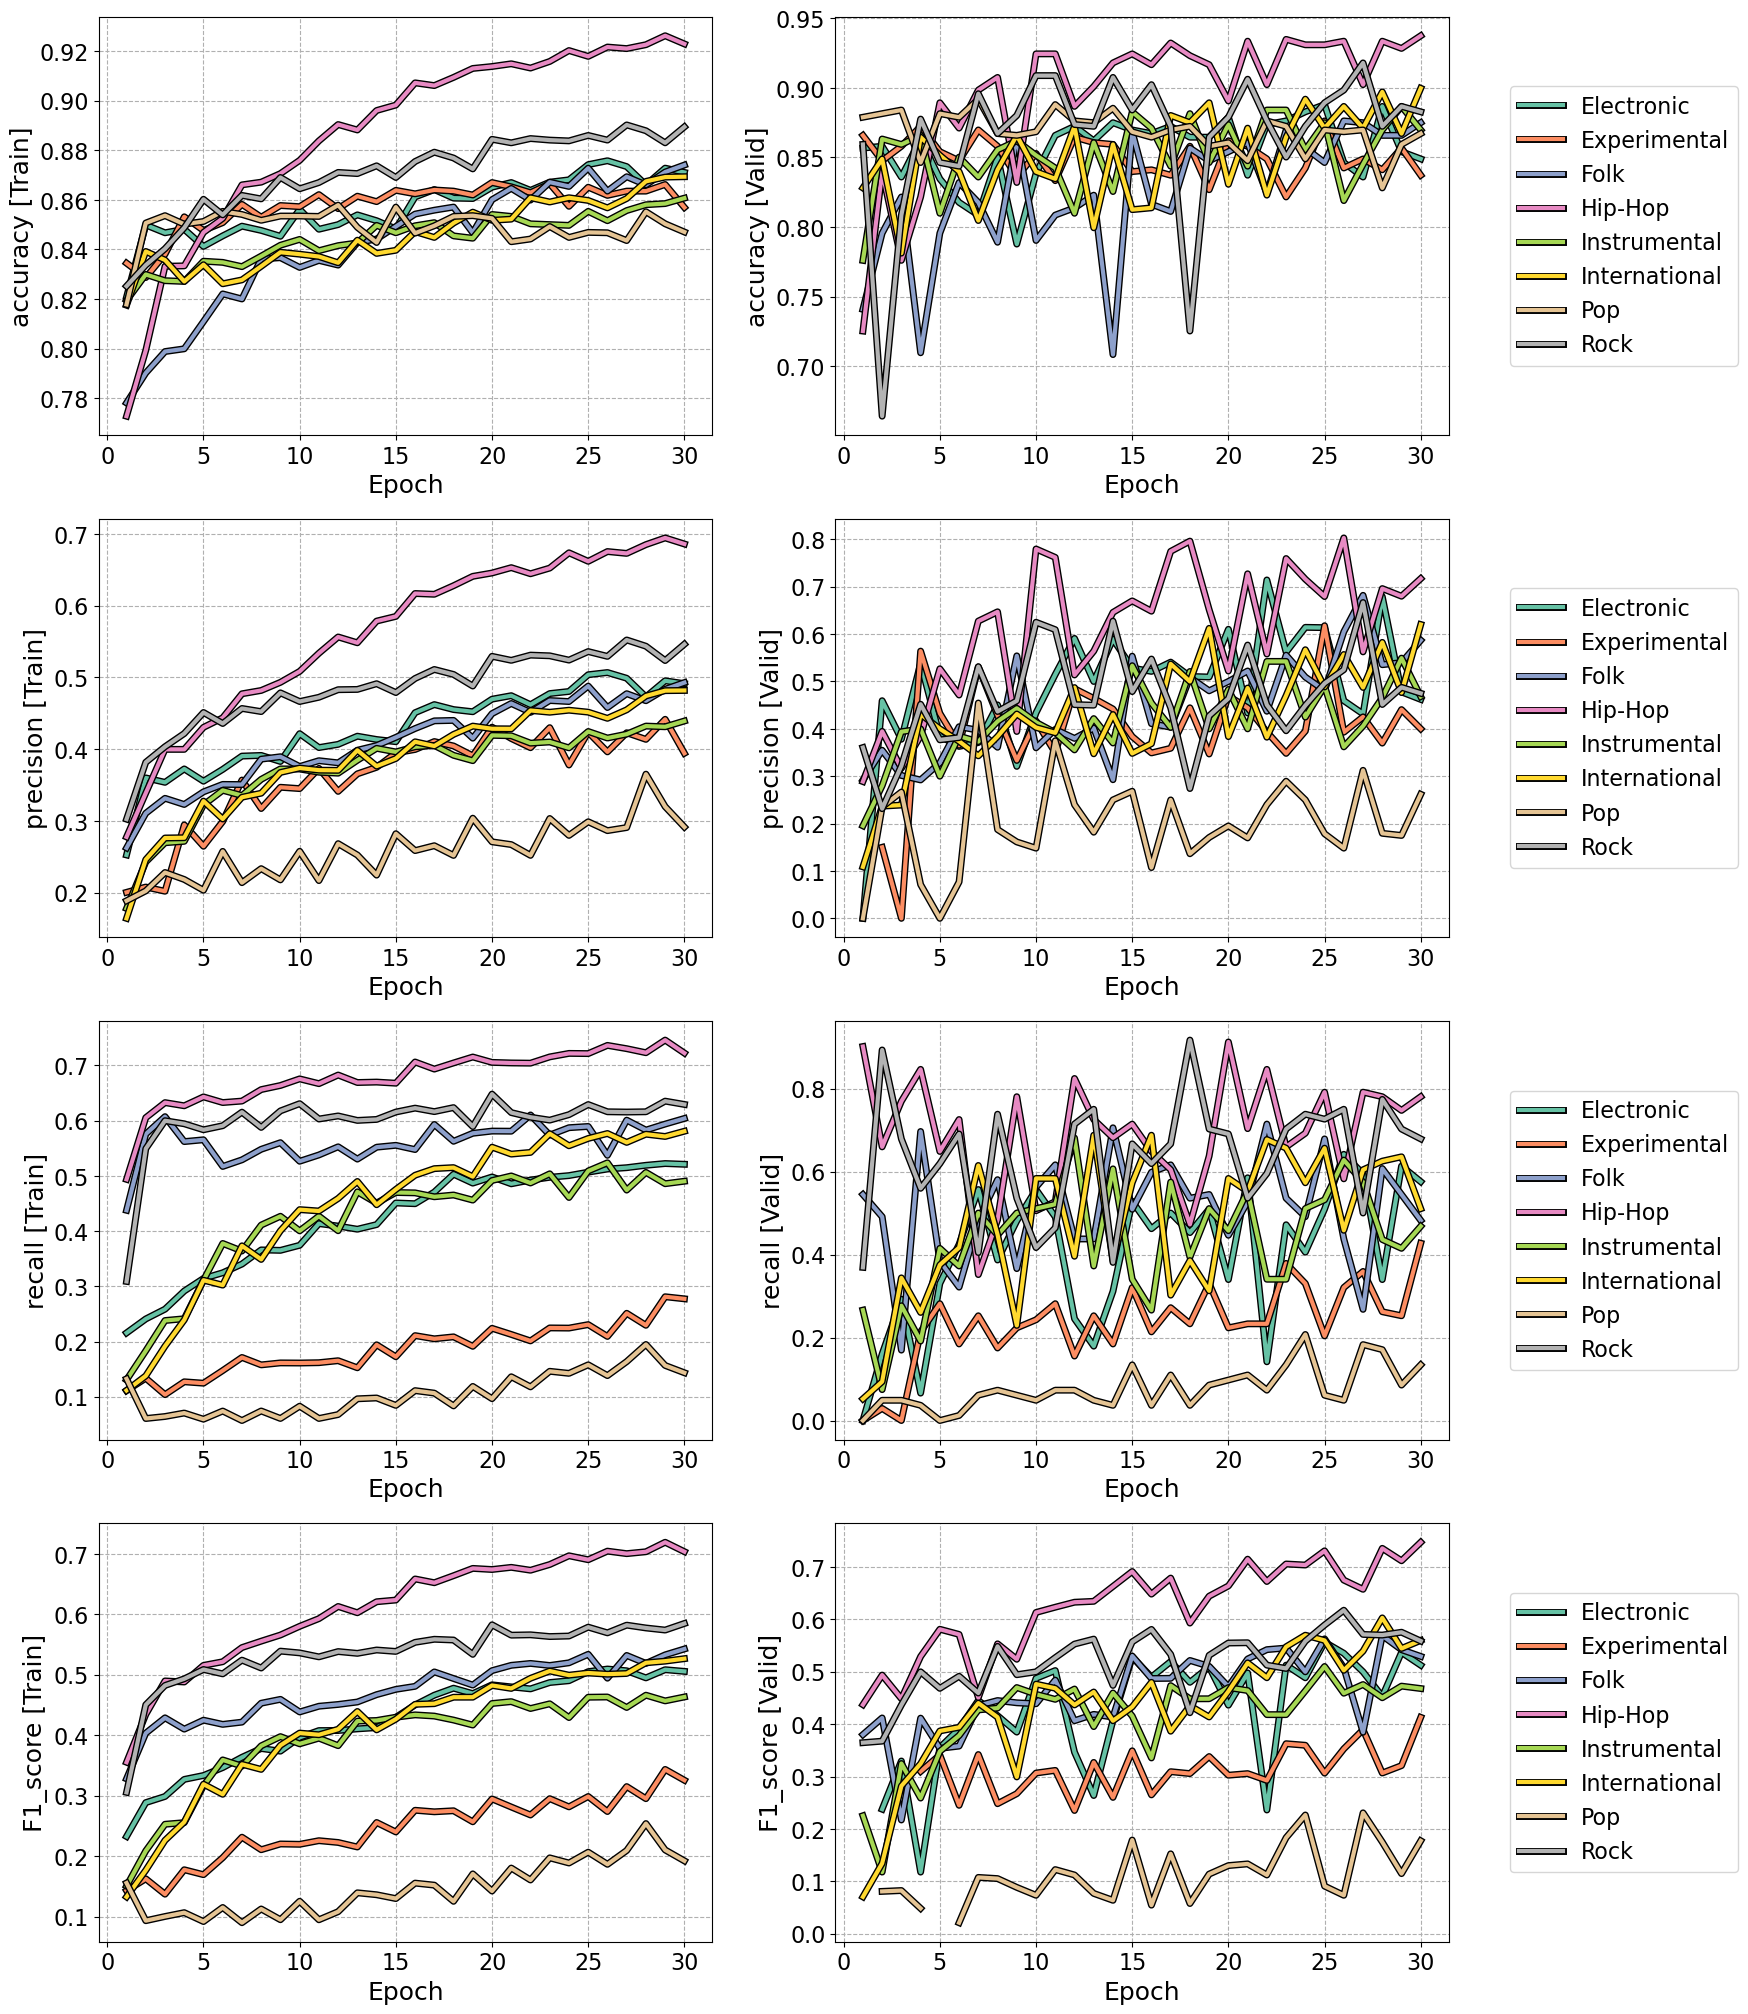

In [76]:
plot_results_per_class('checkpoint_baseline1d.pt', 'results_baseline1d.csv')

## Test model

In [77]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  'checkpoint_baseline1d.pt',
                  'results_baseline1d.csv',
                  'confusion_matrix_baseline1d.csv')

In [78]:
pd.read_csv('./results/test_results_baseline1d.csv').iloc[:,np.arange(0, 10, 2)].style.hide_index()

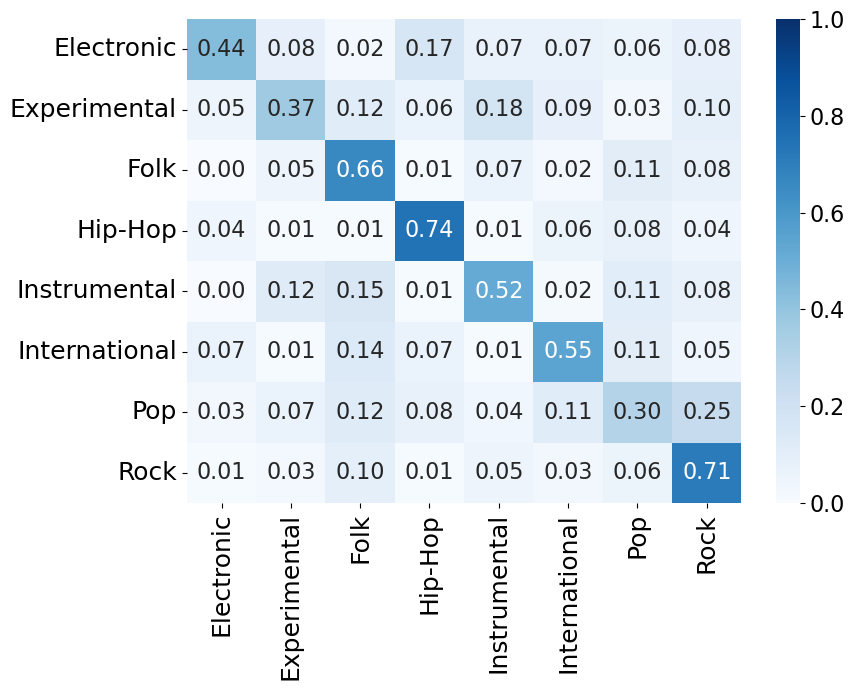

In [79]:
plot_CM('confusion_matrix_baseline1d.csv')

# Baseline 2D: Convolutional Neural Network

## Define model

In [80]:
class ResBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.main_path(x) + self.shortcut_path(x))


class ConvBlock2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            ResBlock2d(1,16),
            nn.MaxPool2d(kernel_size=[8,2]),
            ResBlock2d(16,32),
            nn.MaxPool2d(kernel_size=[4,2]),
            ResBlock2d(32,64),
            nn.MaxPool2d(kernel_size=[4,2]),
            ResBlock2d(64,128)
        )

    def forward(self, x):
        return self.block(x) # [128,1,64]

In [81]:
class Baseline2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = ConvBlock2d()
        self.avg_pool = nn.MaxPool2d(kernel_size=[1,64])
        self.max_pool = nn.AvgPool2d(kernel_size=[1,64])
        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64,8)
        )
        
    def forward(self, x):
        x = self.conv_block(x) # [128,1,64]
        x_avg = self.avg_pool(x) # [128,1,1]
        x_max = self.max_pool(x) # [128,1,1]
        x = torch.cat([x_avg, x_max], dim = 1) # [256,1,1]
        return self.classifier(x.reshape((x.shape[0], -1)))

In [82]:
model = Baseline2d()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 347352


## Create train, valid, and test datasets

In [83]:
train_dataset = MelSpectrogramDataset(train_df, audio_transform=train_audio_transform, spectrogram_normalize=train_spectrogram_normalize)
valid_dataset = MelSpectrogramDataset(valid_df, audio_transform=valid_audio_transform, spectrogram_normalize=valid_spectrogram_normalize)
test_dataset = MelSpectrogramDataset(test_df, audio_transform=test_audio_transform, spectrogram_normalize=test_spectrogram_normalize)

## Create iterators over datasets

In [84]:
BATCH_SIZE = 32

# create iterators
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [85]:
#sample_info(next(iter(train_iterator)), names=['spectrogram', 'genre'])

## Train model

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print('{} {} GPU available'.format(str(device_count), str(device_name)))

1 Tesla T4 GPU available


In [87]:
model = Baseline2d()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 30

In [88]:
TRAIN = False

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          'checkpoint_baseline2d.pt',
                                                          'results_baseline2d.csv')

## Plot results

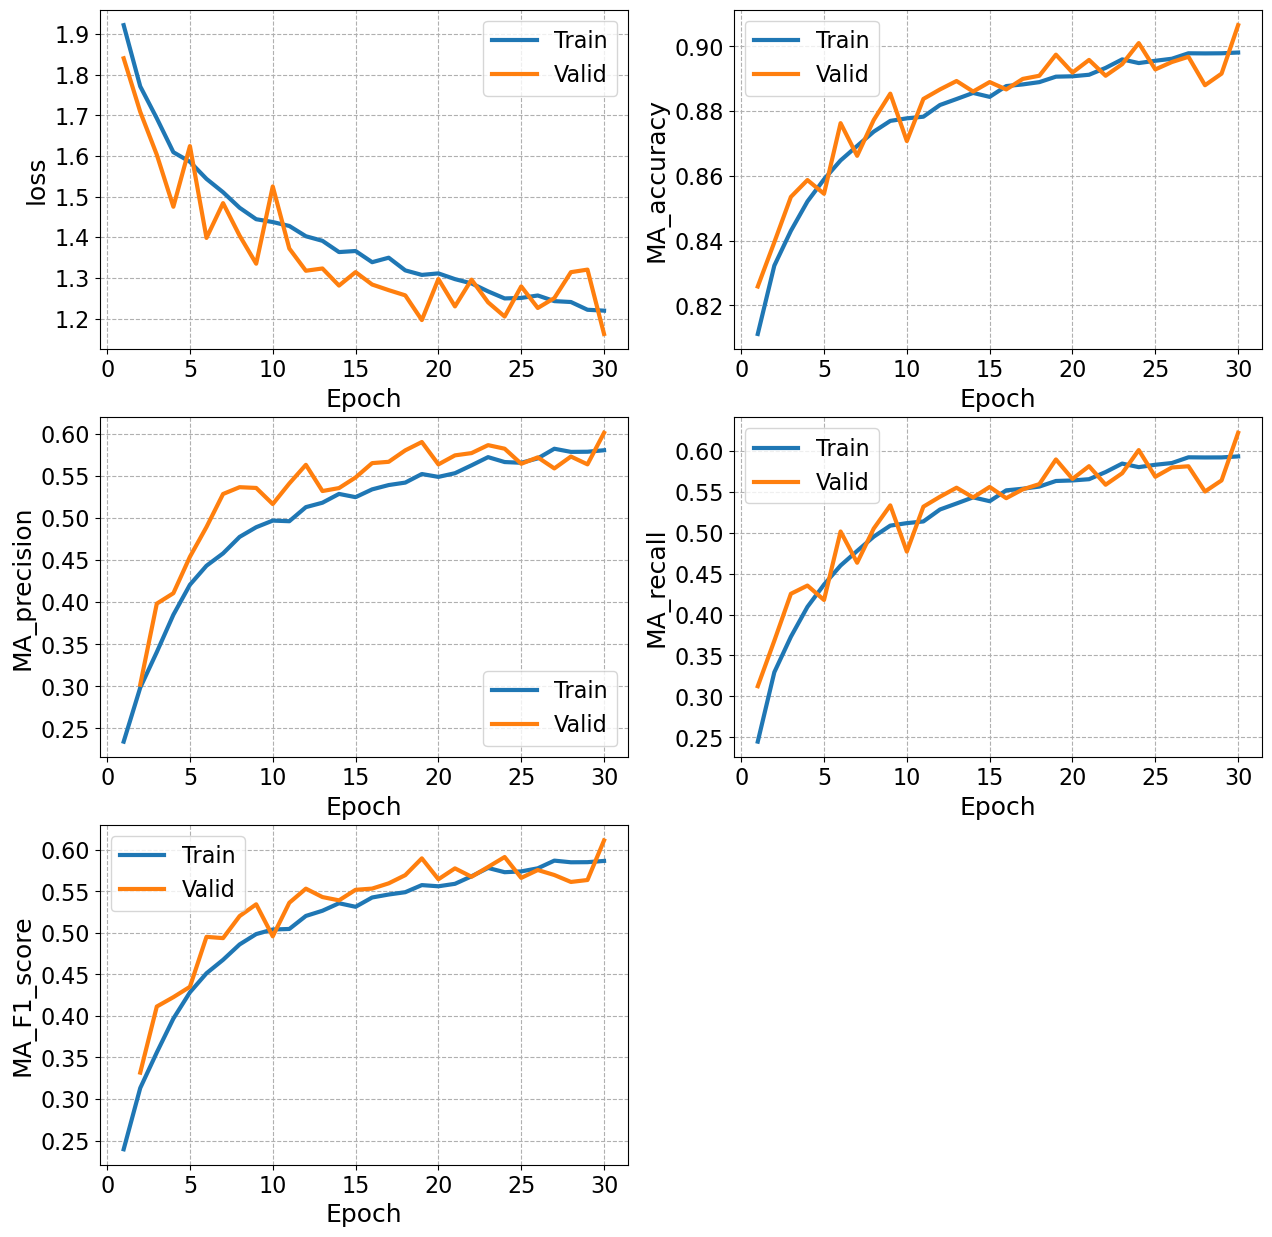

In [89]:
plot_results('checkpoint_baseline2d.pt', 'results_baseline2d.csv')

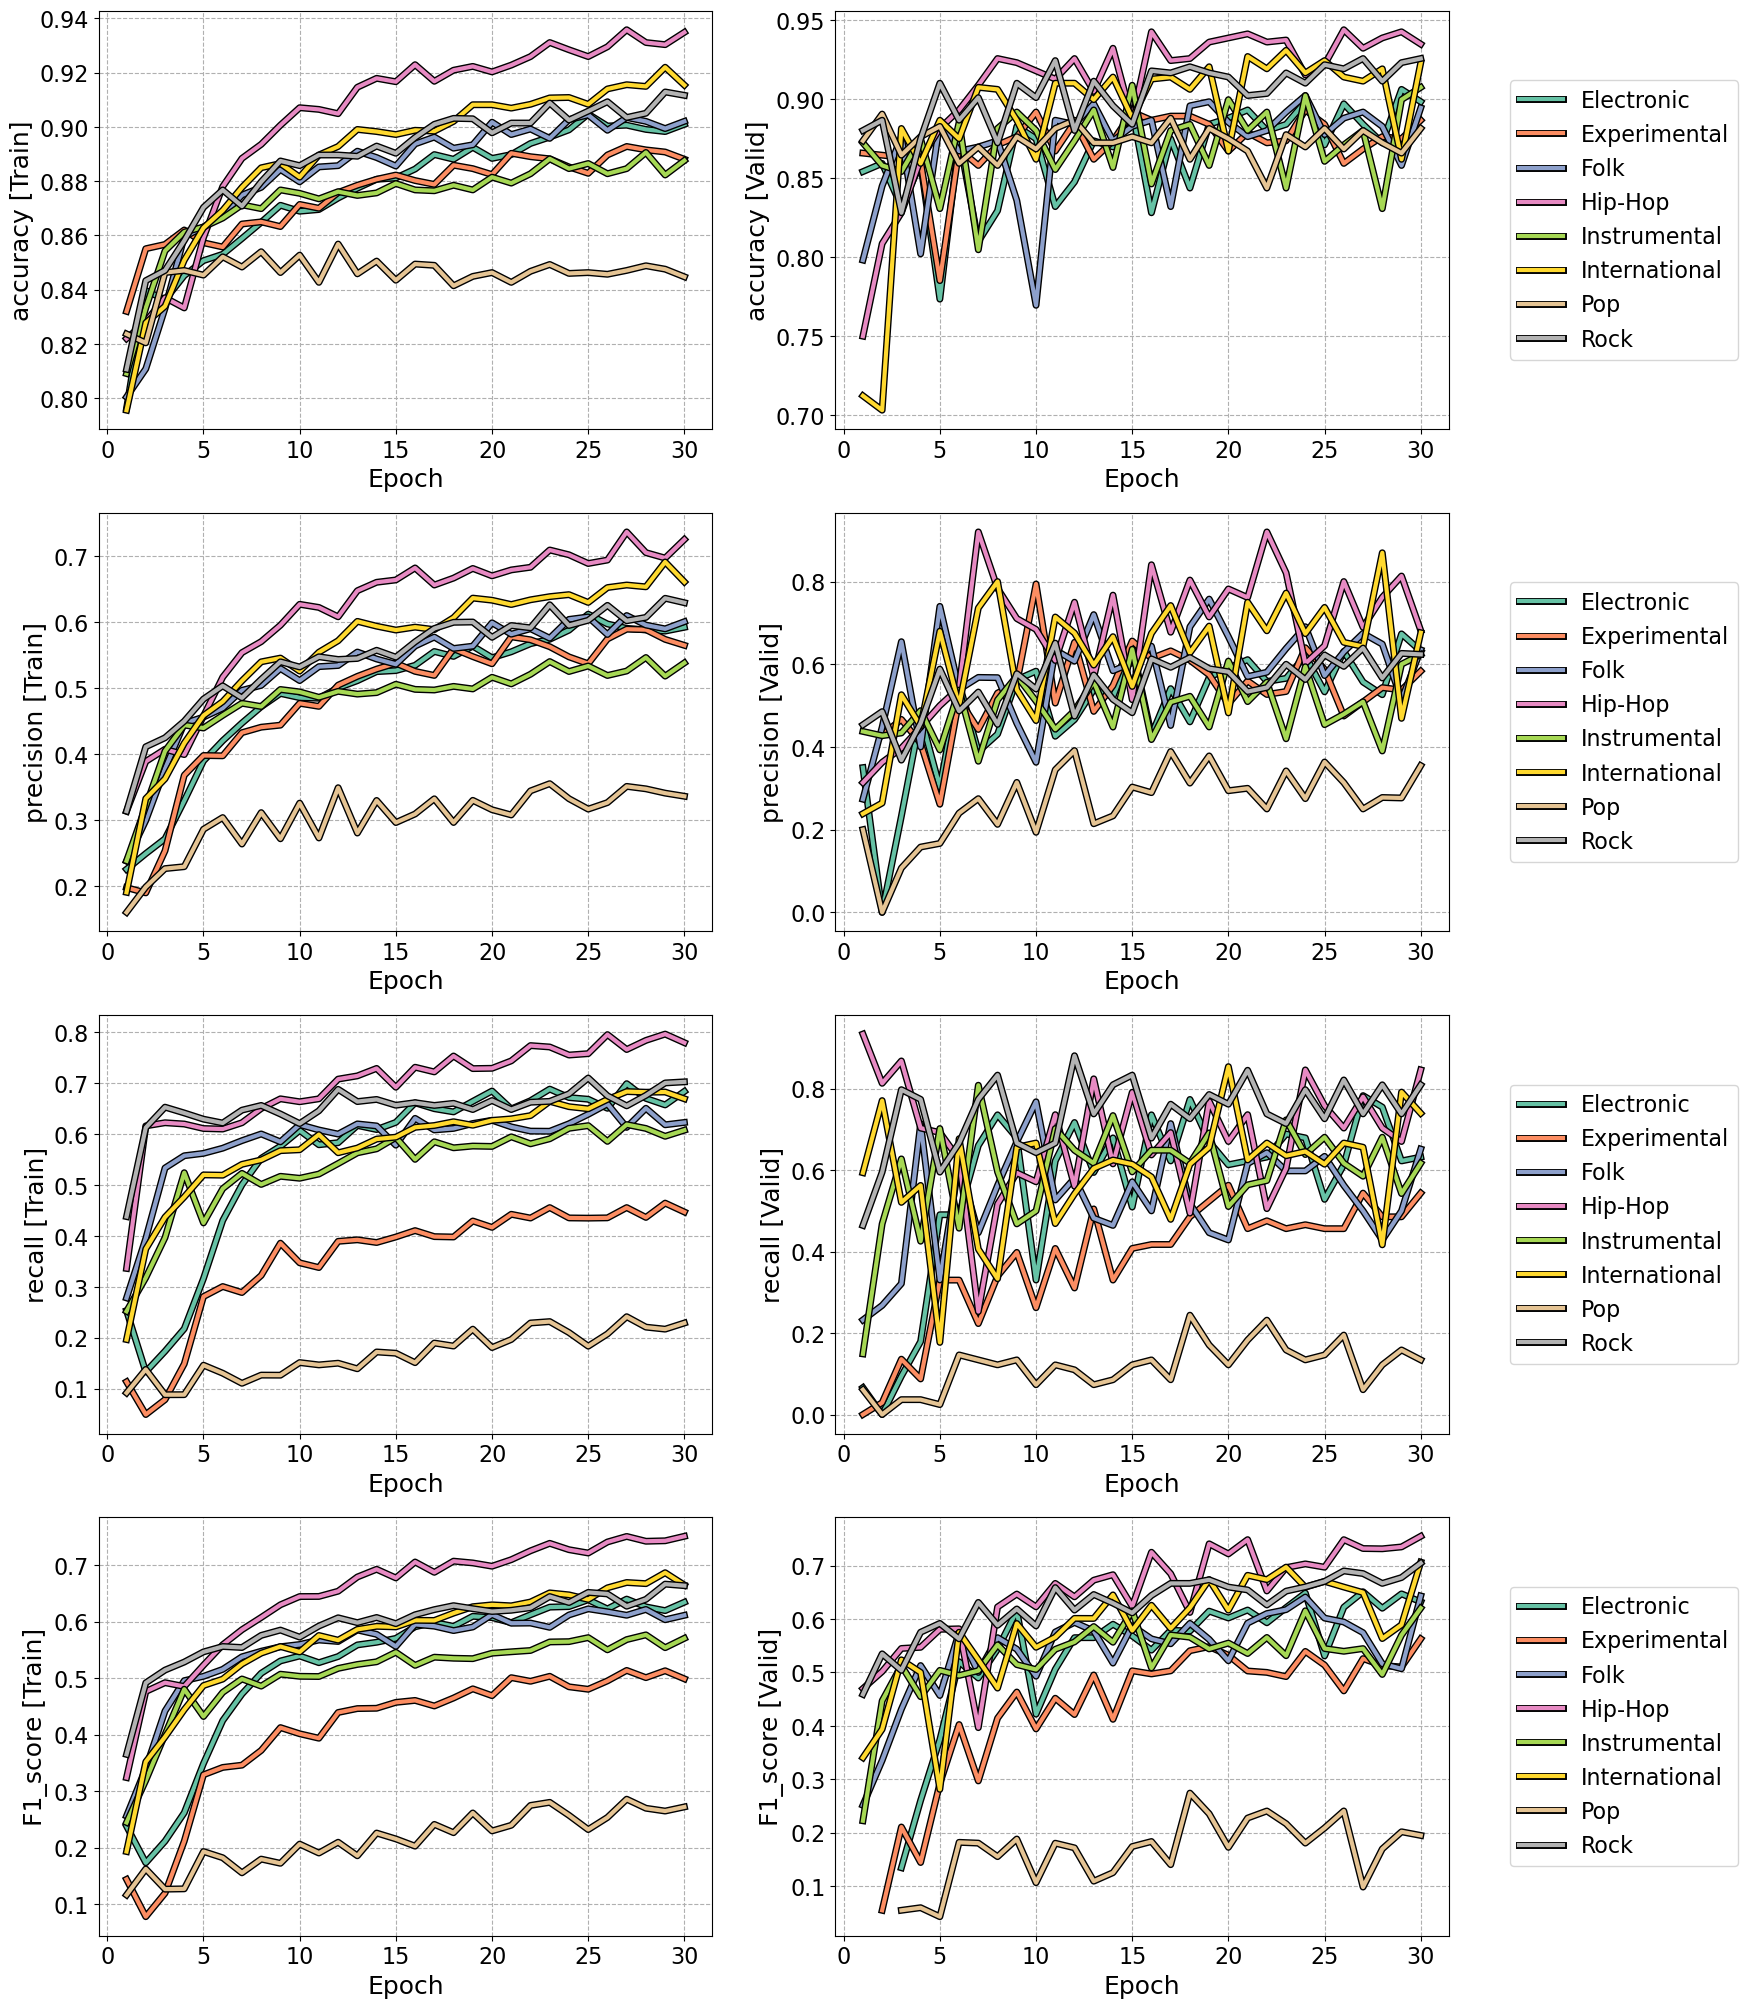

In [90]:
plot_results_per_class('checkpoint_baseline2d.pt', 'results_baseline2d.csv')

## Test model

In [91]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion, device,
                  'checkpoint_baseline2d.pt',
                  'results_baseline2d.csv',
                  'confusion_matrix_baseline2d.csv')

In [92]:
pd.read_csv('./results/test_results_baseline2d.csv').iloc[:,np.arange(0, 10, 2)].style.hide_index()

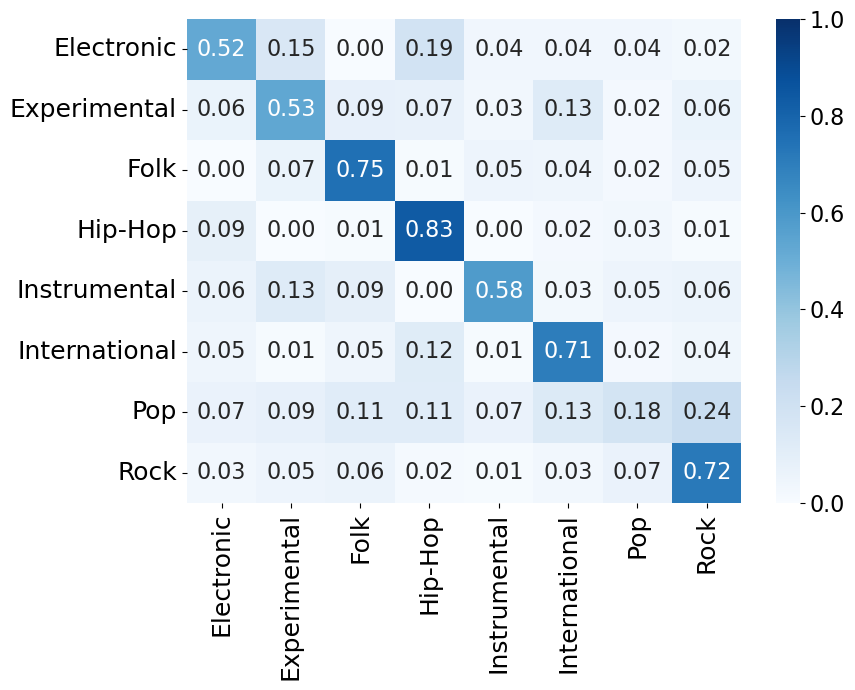

In [93]:
plot_CM('confusion_matrix_baseline2d.csv')

# Convolutional Recurrent Neural Network

## Define model

In [94]:
class Recurrent(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = ConvBlock2d() # [128,1,64]
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(128,8)
    
    def forward(self, x):
        x = self.conv_block(x)
        # batch size, sequence length, feature size
        x = x.reshape((x.shape[0], x.shape[3], x.shape[1]))
        out, _ = self.lstm(x)
        # take the last one
        out = self.dropout(out[:,-1,:])
        return self.classifier(out)

In [95]:
model = Recurrent()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 438808


## Create train, valid, and test datasets

In [96]:
train_dataset = MelSpectrogramDataset(train_df, audio_transform=train_audio_transform, spectrogram_normalize=train_spectrogram_normalize)
valid_dataset = MelSpectrogramDataset(valid_df, audio_transform=valid_audio_transform, spectrogram_normalize=valid_spectrogram_normalize)
test_dataset = MelSpectrogramDataset(test_df, audio_transform=test_audio_transform, spectrogram_normalize=test_spectrogram_normalize)

## Create iterators over datasets

In [97]:
BATCH_SIZE = 32

# create iterators
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [98]:
#sample_info(next(iter(train_iterator)), names=['spectrogram', 'genre'])

## Train model

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print('{} {} GPU available'.format(str(device_count), str(device_name)))

1 Tesla T4 GPU available


In [100]:
model = Recurrent()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 25

In [101]:
TRAIN = False

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          'checkpoint_recurrent.pt',
                                                          'results_recurrent.csv')

## Plot results

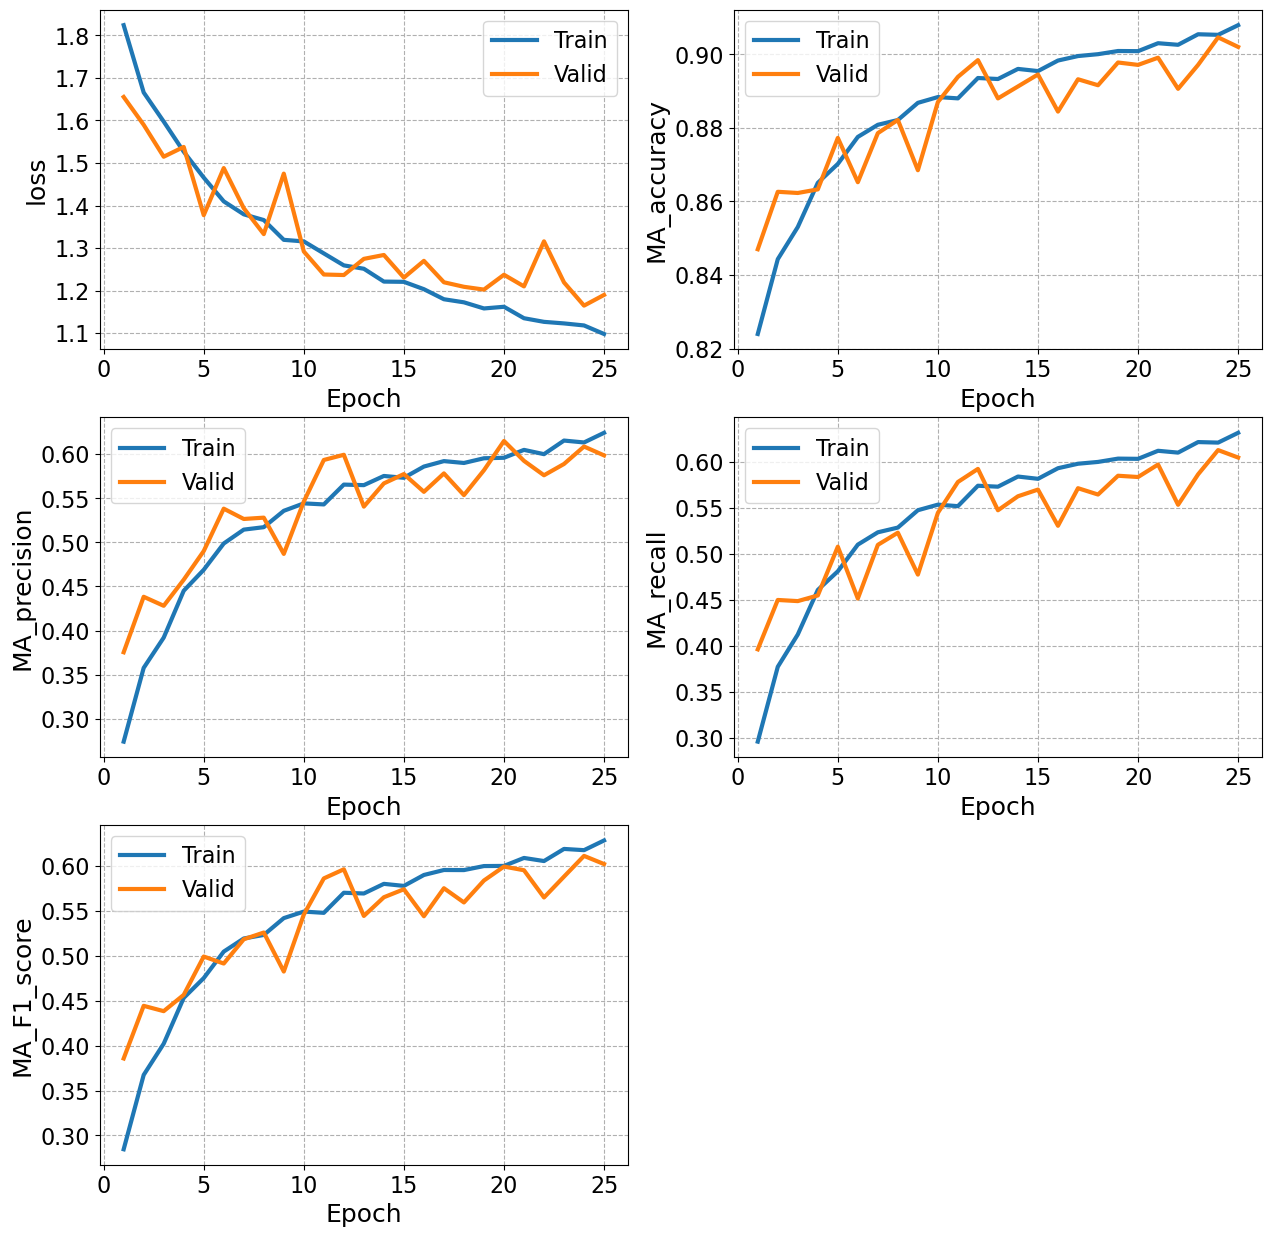

In [102]:
plot_results('checkpoint_recurrent.pt', 'results_recurrent.csv')

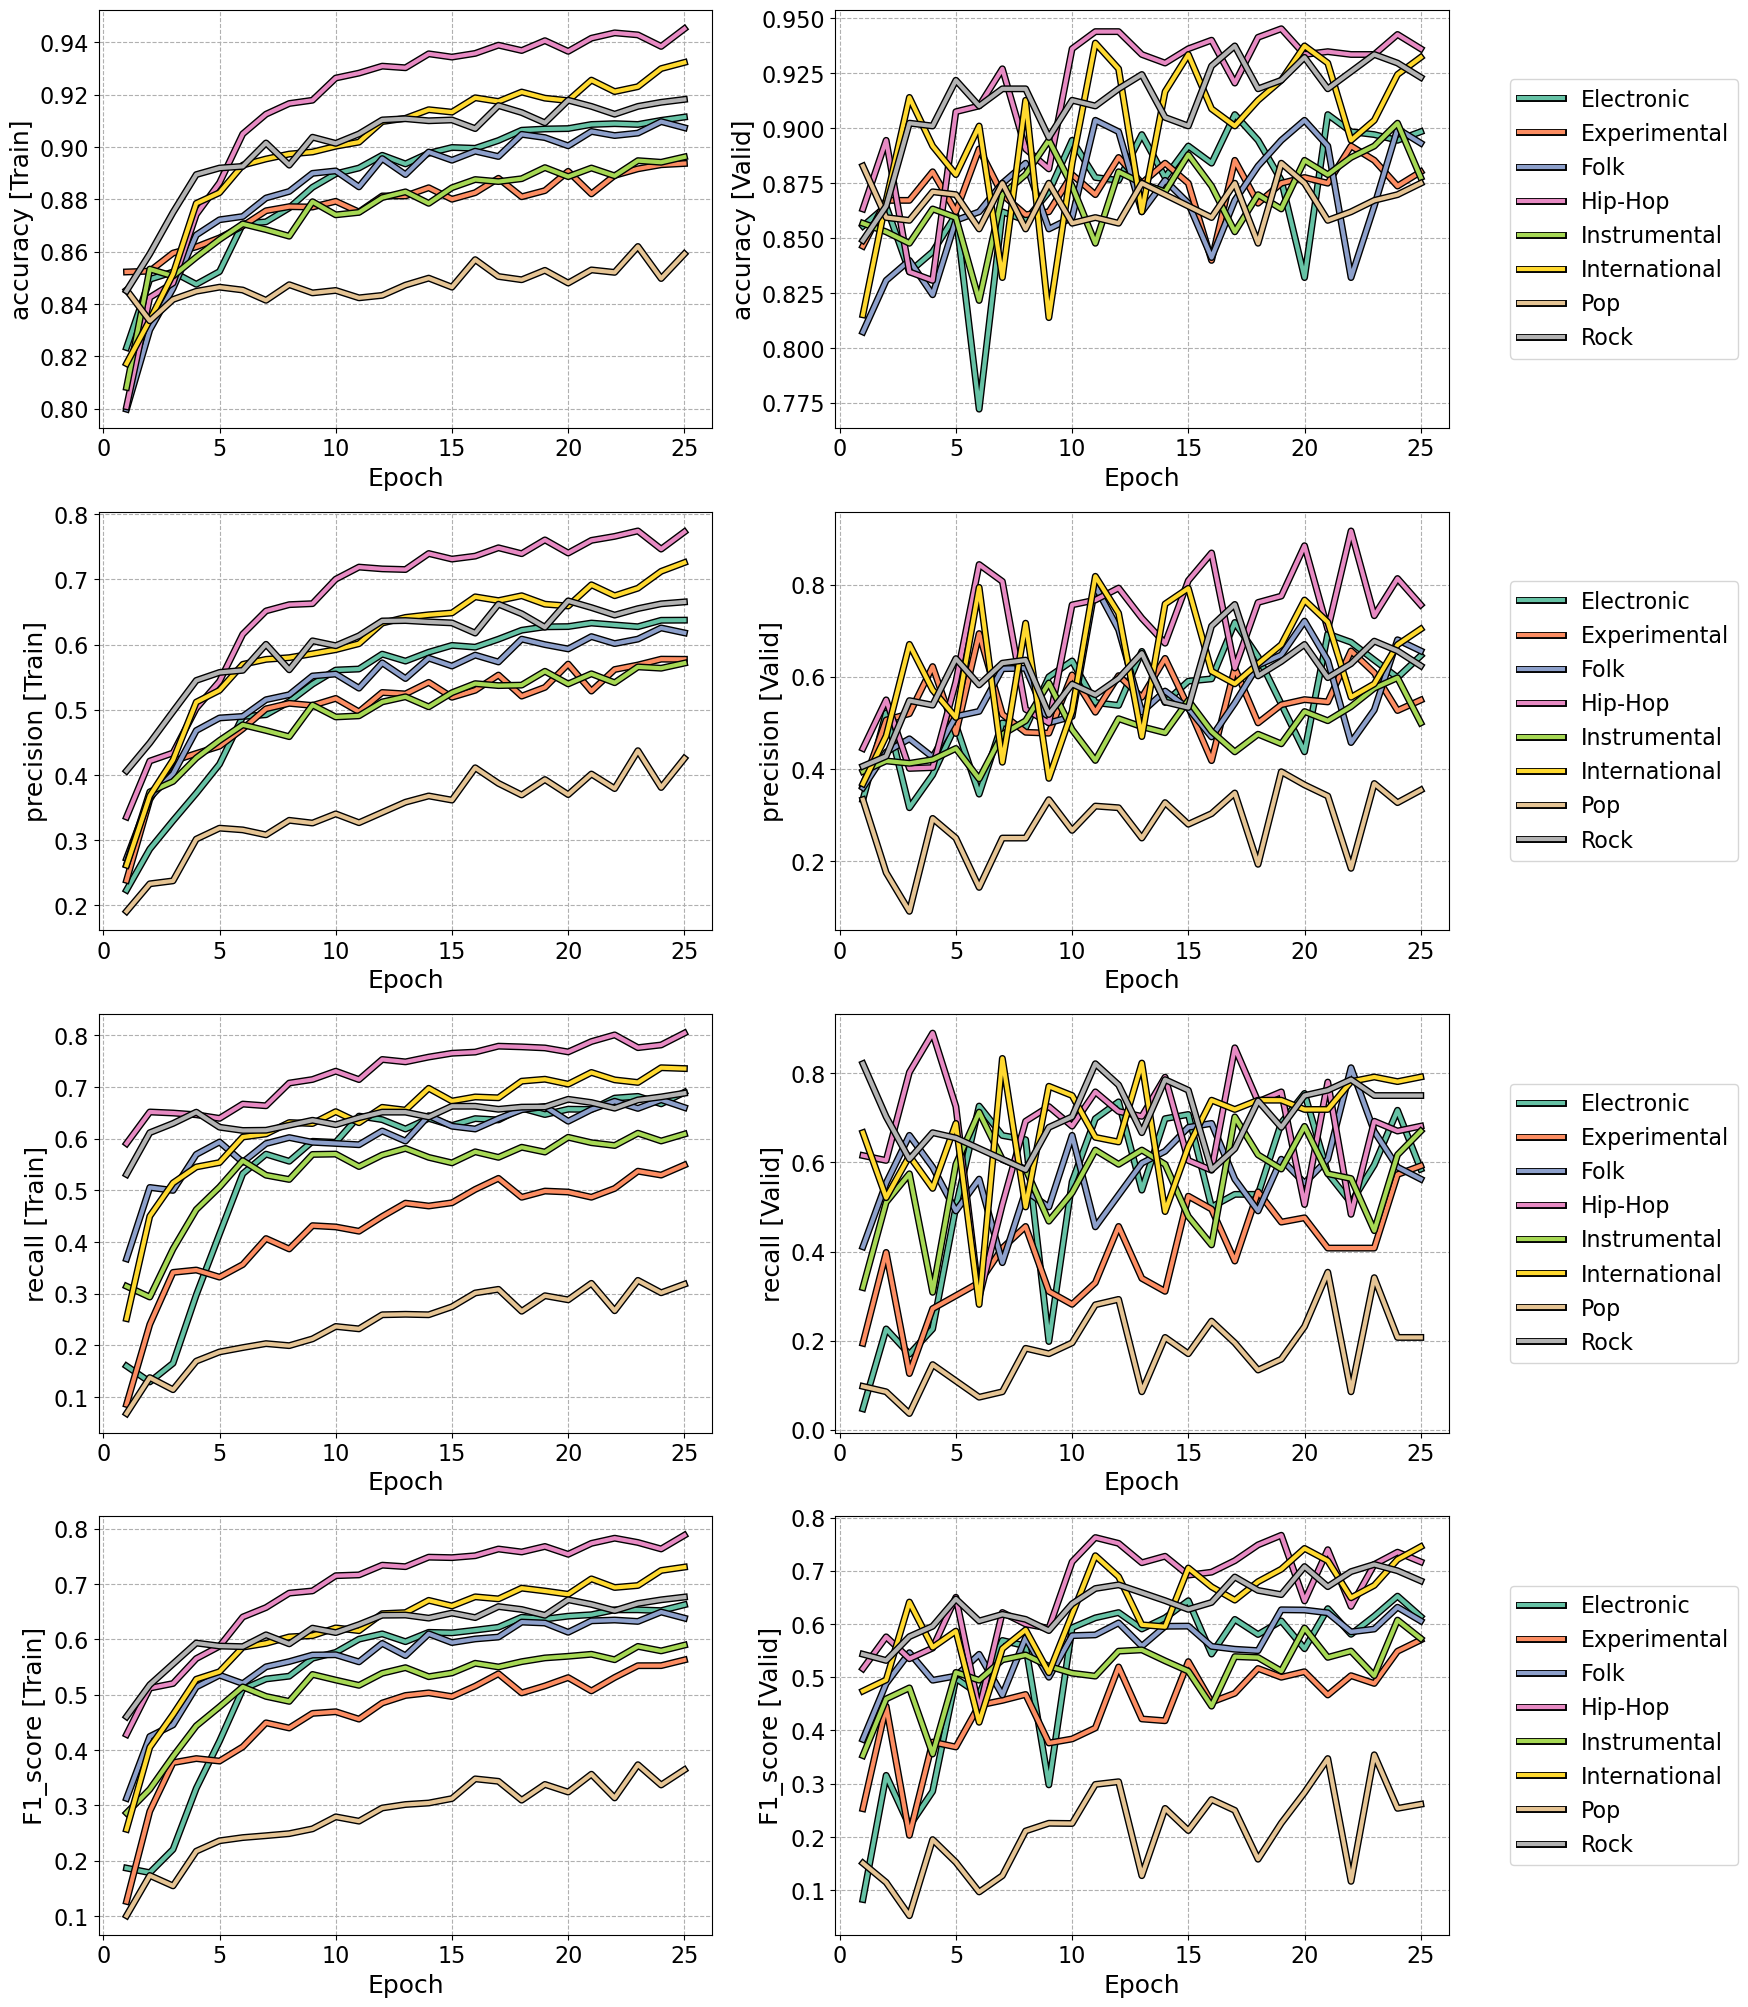

In [103]:
plot_results_per_class('checkpoint_recurrent.pt', 'results_recurrent.csv')

## Test model

In [104]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion, device,
                  'checkpoint_recurrent.pt',
                  'results_recurrent.csv',
                  'confusion_matrix_recurrent.csv')

In [105]:
pd.read_csv('./results/test_results_recurrent.csv').iloc[:,np.arange(0, 10, 2)].style.hide_index()

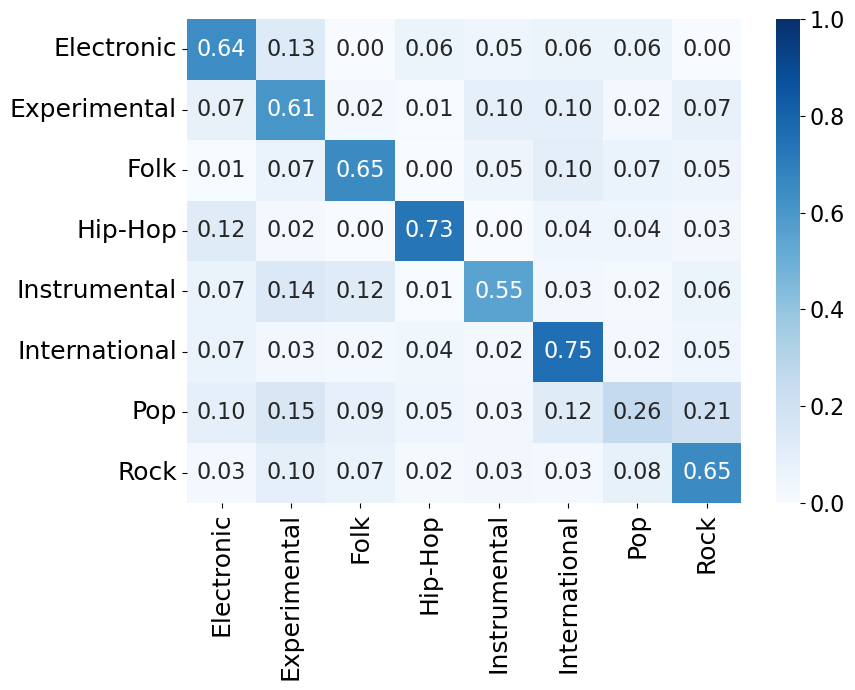

In [106]:
plot_CM('confusion_matrix_recurrent.csv')

# Multi-Modal Recurrent Convolutional Neural Network

## Define model

In [107]:
class CombinedRecurrent(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_1d = ConvBlock1d()
        self.conv_block_2d = ConvBlock2d()
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(128,8)

    
    def forward(self, x_1d, x_2d):
        x_1d = self.conv_block_1d(x_1d) # [128,65]
        x_1d = x_1d[:,:,None,:64]
        x_2d = self.conv_block_2d(x_2d) # [128,1,64]
        # concatenate along temporal dimension
        x = torch.cat([x_1d, x_2d], dim=1) # [256,1,64]
        # batch size, sequence length, feature size
        x = x.reshape((x.shape[0], x.shape[3], x.shape[1])) # [64,256]
        out, _ = self.lstm(x)
        # take the last one
        out = self.dropout(out[:,-1,:])
        return self.classifier(out)

In [108]:
model = CombinedRecurrent()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 623848


## Create train, valid, and test datasets

In [109]:
train_dataset = MelSpectrogramDataset(train_df, audio_transform=train_audio_transform, audio_normalize=train_audio_normalize, spectrogram_normalize=train_spectrogram_normalize, double_output=True)
valid_dataset = MelSpectrogramDataset(valid_df, audio_transform=valid_audio_transform, audio_normalize=valid_audio_normalize, spectrogram_normalize=valid_spectrogram_normalize, double_output=True)
test_dataset = MelSpectrogramDataset(test_df, audio_transform=test_audio_transform, audio_normalize=test_audio_normalize, spectrogram_normalize=test_spectrogram_normalize, double_output=True)

## Create iterators over datasets

In [110]:
BATCH_SIZE = 32

# create iterators
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [111]:
#sample_info(next(iter(train_iterator)), names=['audio', 'spectrogram', 'genre'])

## Train model

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print('{} {} GPU available'.format(str(device_count), str(device_name)))

1 Tesla T4 GPU available


In [113]:
model = CombinedRecurrent()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)

scheduler = None

N_EPOCHS = 20

In [114]:
TRAIN = False

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          'checkpoint_combinedrecurrent.pt',
                                                          'results_combinedrecurrent.csv')

## Plot results

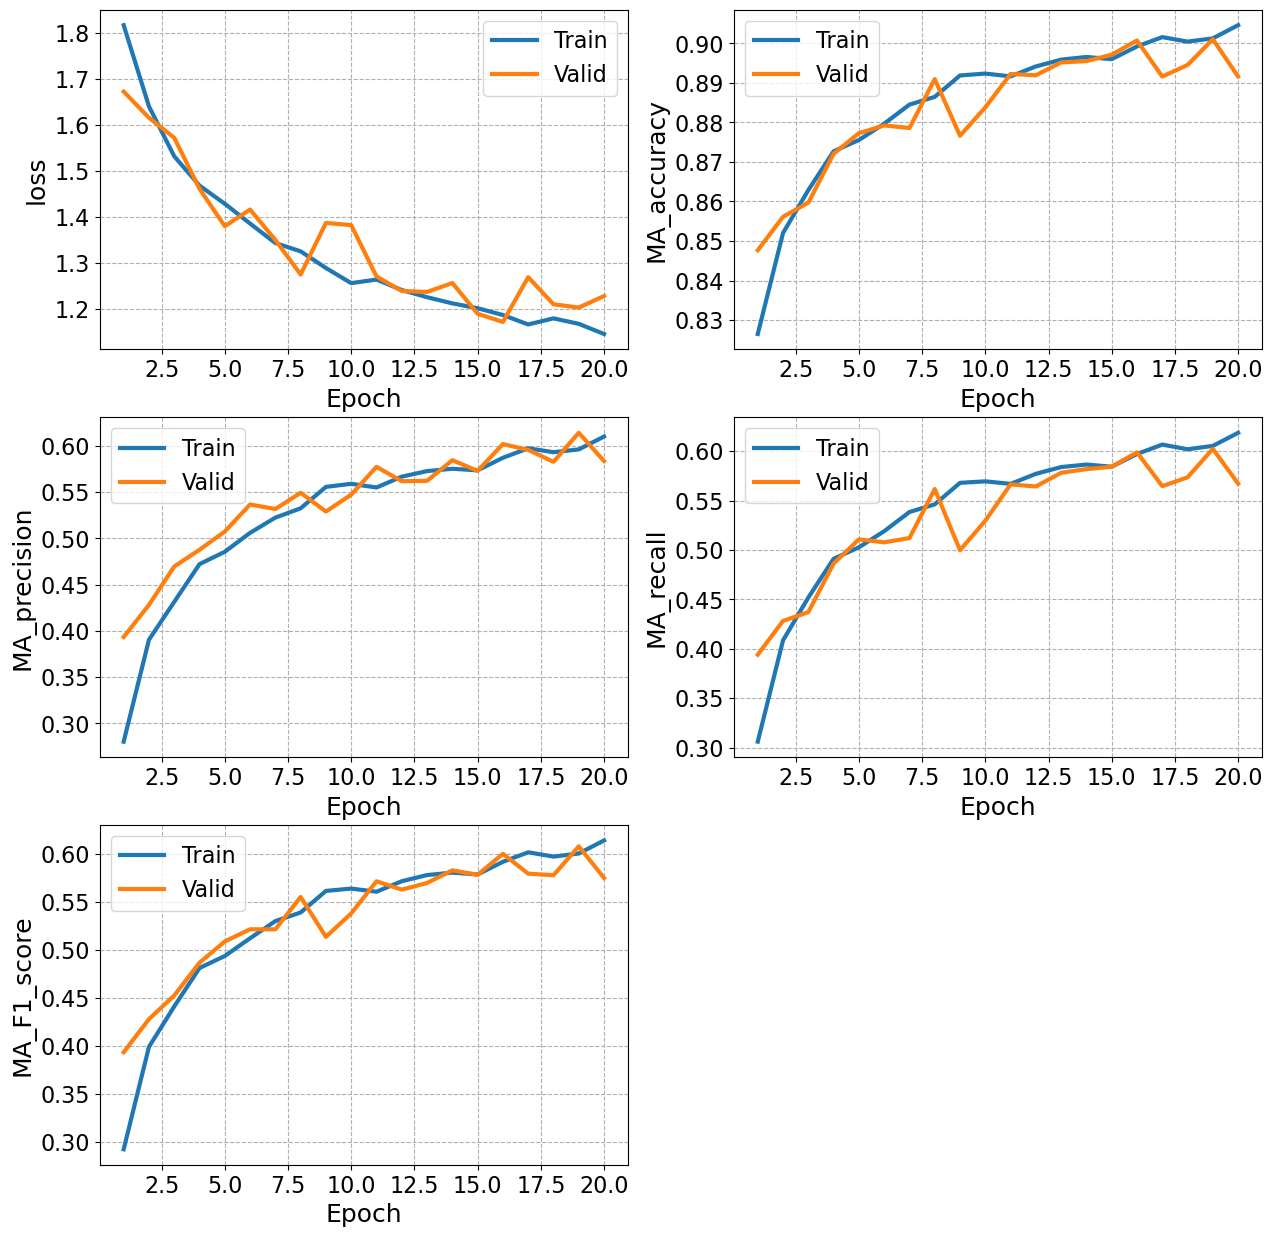

In [115]:
plot_results('checkpoint_combinedrecurrent.pt', 'results_combinedrecurrent.csv')

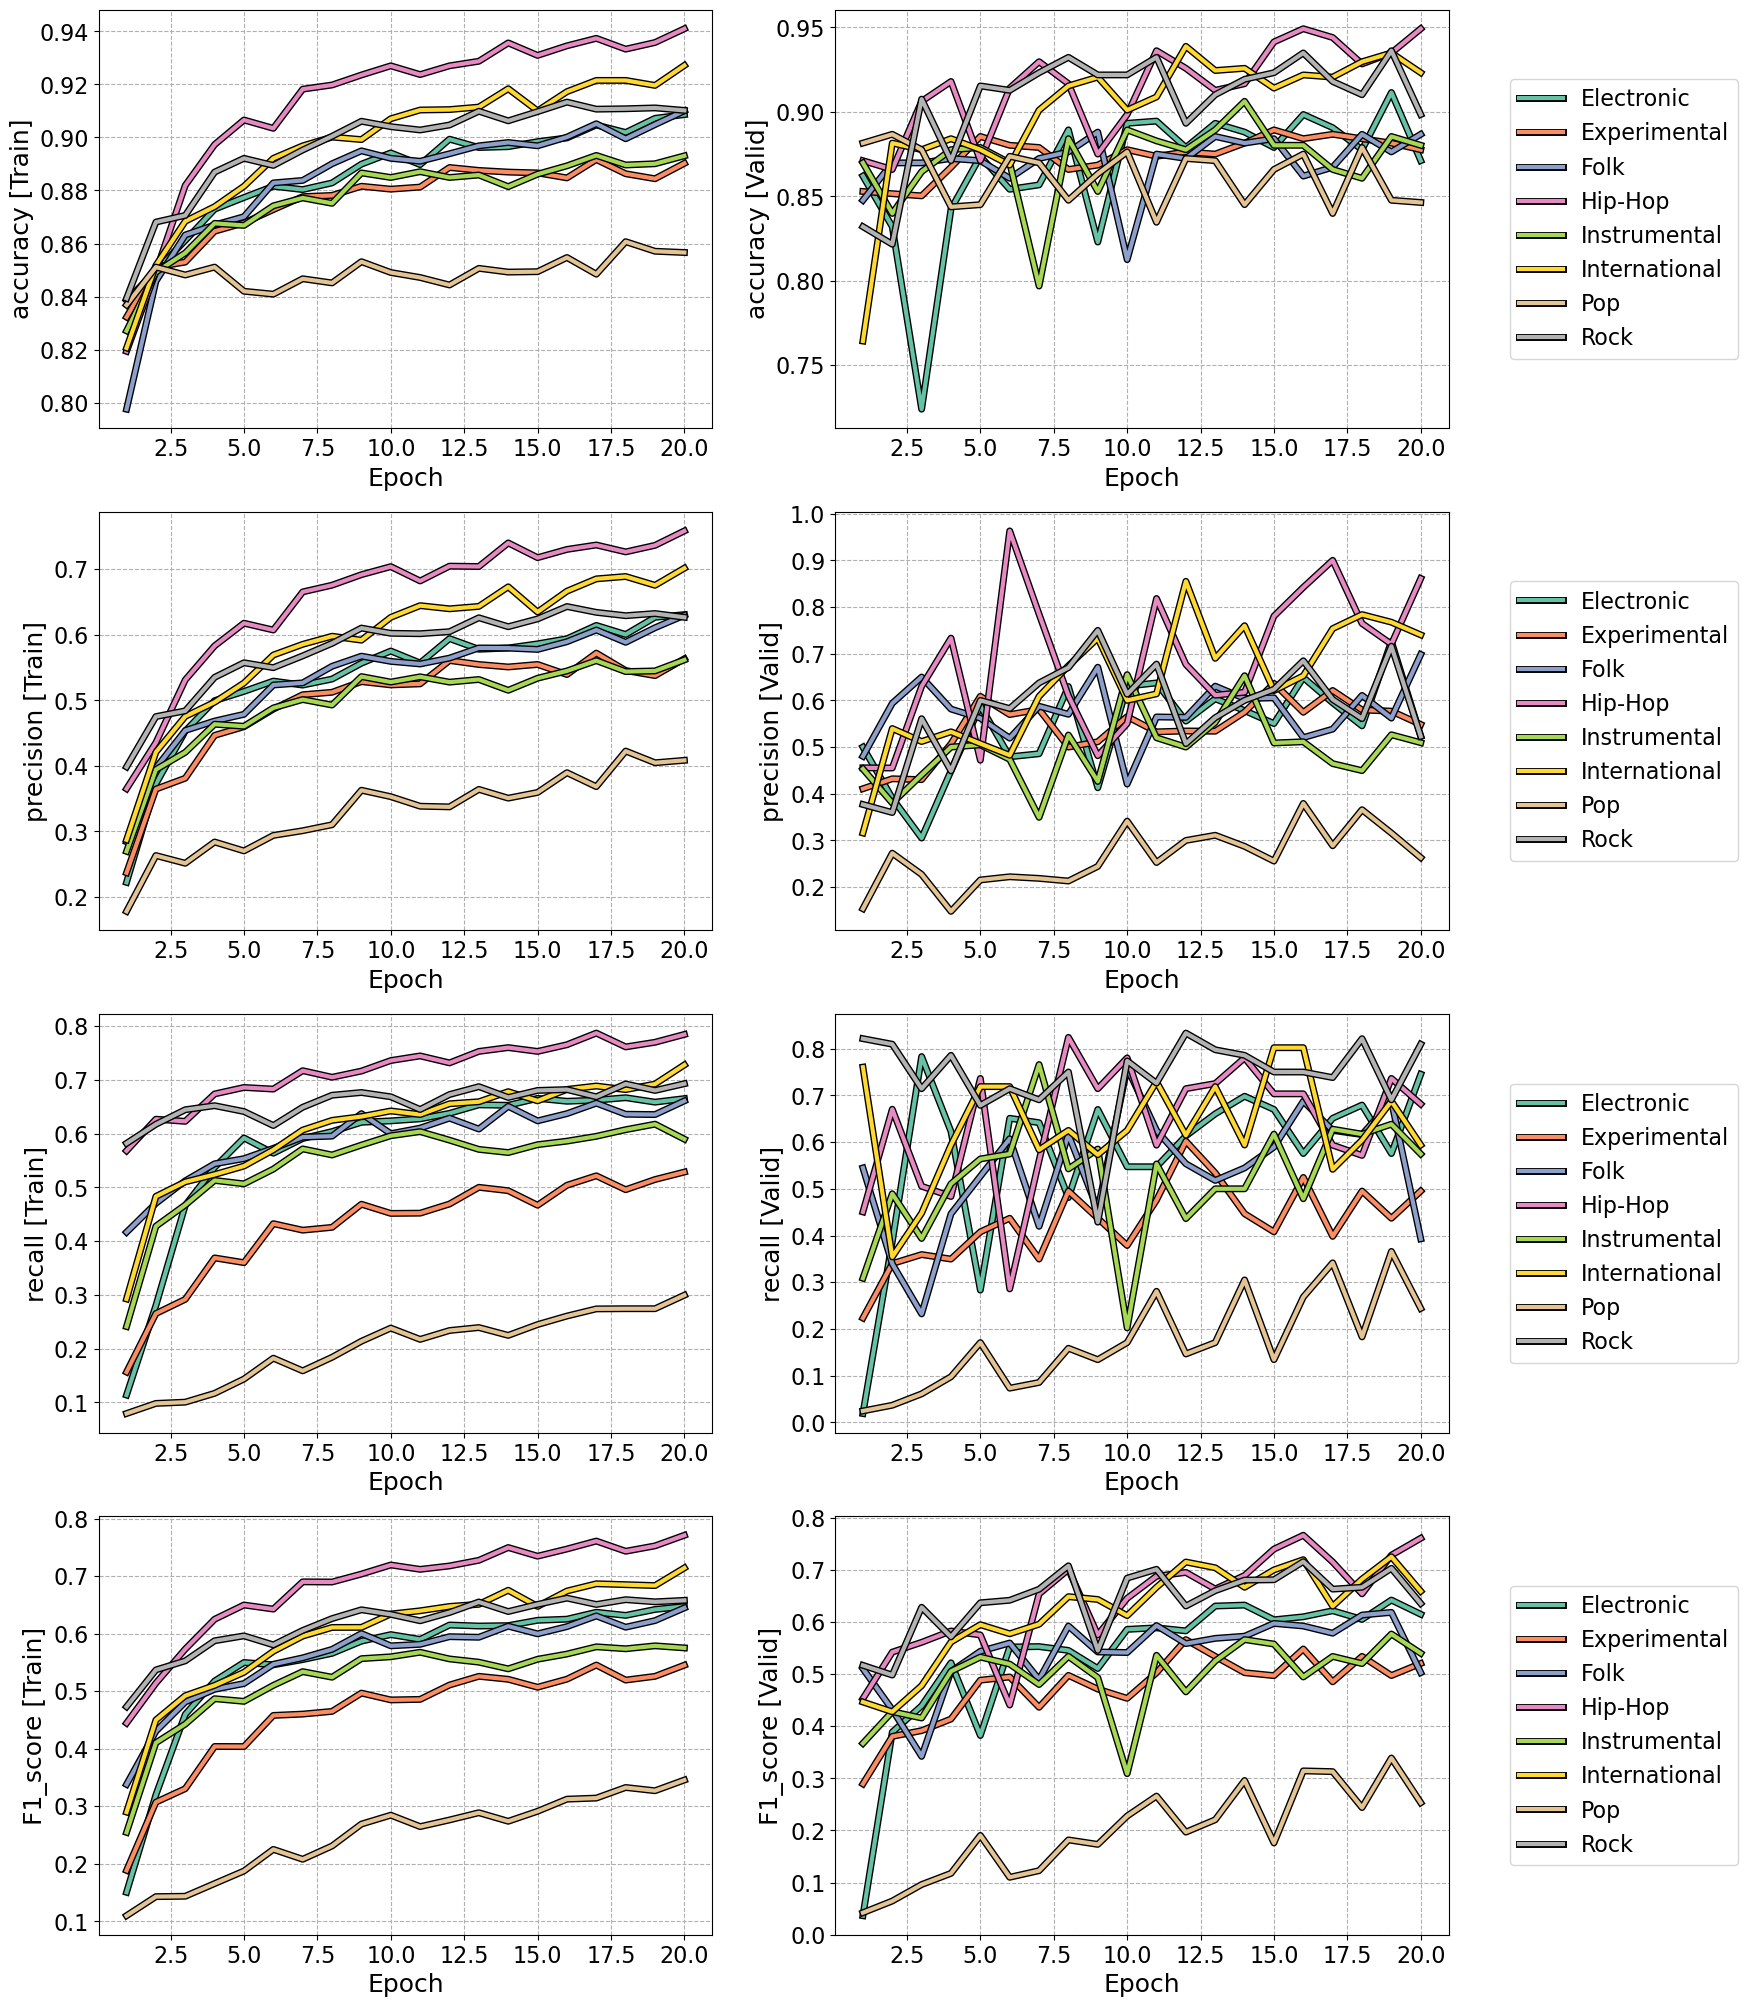

In [116]:
plot_results_per_class('checkpoint_combinedrecurrent.pt', 'results_combinedrecurrent.csv')

## Test model

In [117]:
TEST = False

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  'checkpoint_combinedrecurrent.pt',
                  'results_combinedrecurrent.csv',
                  'confusion_matrix_combinedrecurrent.csv')

In [118]:
pd.read_csv('./results/test_results_combinedrecurrent.csv').iloc[:,np.arange(0, 10, 2)].style.hide_index()

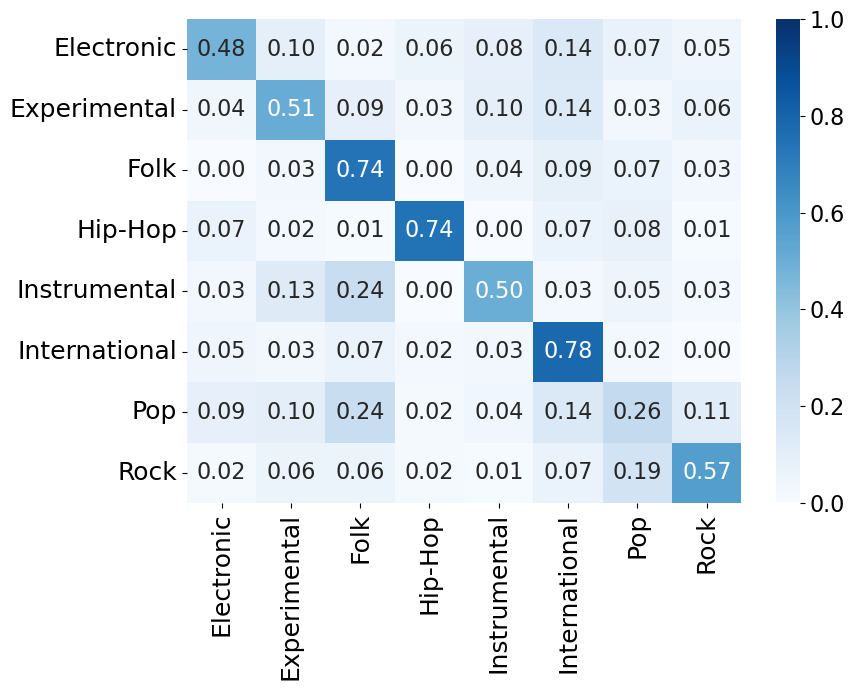

In [119]:
plot_CM('confusion_matrix_combinedrecurrent.csv')

# Compare models

In [120]:
def plot_loss(checkpoint_names, results_names):
    
    model_names = ['1-D CNN', '2-D CNN', 'CRNN', 'MM-CRNN']
    
    best_epoch = [] #[28,30,23,16]
    train_results_dfs = [] 
    valid_results_dfs = [] 
    
    # loop over models
    for i in range(len(model_names)):
        
        # get best epoch from checpoint
        best_epoch.append(torch.load(os.path.join('./checkpoints', checkpoint_names[i]))['epoch'])
        
        # load train results
        train_results_dfs.append(pd.read_csv('./results/train_' + results_names[i]).iloc[:best_epoch[i]])
        
        # load valid results
        valid_results_dfs.append(pd.read_csv('./results/valid_' + results_names[i]).iloc[:best_epoch[i]])   
        
        assert len(train_results_dfs[i]) == len(valid_results_dfs[i])  
    
    
    fig, ax = plt.subplots(figsize=(8,6))

    color_map = plt.get_cmap('Dark2')
    
    # loop over models
    for i in range(len(model_names)):
 
        # train
        plt.plot(np.arange(best_epoch[i])+1, train_results_dfs[i]['loss'], linewidth=3, color=color_map(3-i), label=model_names[i])
        
        # valid
        plt.plot(np.arange(best_epoch[i])+1, valid_results_dfs[i]['loss'], linewidth=2, color=color_map(3-i), linestyle='--', alpha=0.5)
            
        plt.xlim(-1, 31)
        plt.ylim(0.975,2.025)
        
        plt.xlabel('Epoch', fontsize=18)
        plt.ylabel('Loss', fontsize=18)

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),
           loc='lower left',
           mode='expand',
           borderaxespad=0,
           ncol=2,
           fontsize=14)
        
        #plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, fontsize=16)
        plt.legend(fontsize=18)
        
        plt.grid(ls='--', zorder=1)
        
    #plt.savefig('./images/Loss.pdf', dpi=1200, bbox_inches='tight')
    plt.show()

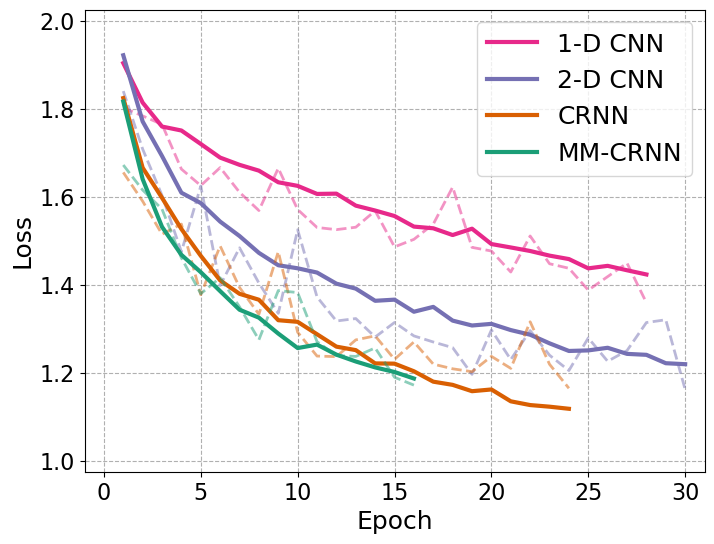

In [121]:
plot_loss(['checkpoint_baseline1d.pt', 'checkpoint_baseline2d.pt', 'checkpoint_recurrent.pt', 'checkpoint_combinedrecurrent.pt'],
          ['results_baseline1d.csv', 'results_baseline2d.csv', 'results_recurrent.csv', 'results_combinedrecurrent.csv'])

In [122]:
def plot_macro_F1_score(checkpoint_names, results_names):
    
    model_names = ['1-D CNN', '2-D CNN', 'CRNN', 'MM-CRNN']
    
    best_epoch = [] # [28,30,23,16]
    train_results_dfs = [] 
    valid_results_dfs = [] 
    
    # loop over models
    for i in range(len(model_names)):
        
        # get best epoch from checpoint
        best_epoch.append(torch.load(os.path.join('./checkpoints', checkpoint_names[i]))['epoch'])
    
        # load train results
        train_results_dfs.append(pd.read_csv('./results/train_' + results_names[i]).iloc[:best_epoch[i]])
        
        # load valid results
        valid_results_dfs.append(pd.read_csv('./results/valid_' + results_names[i]).iloc[:best_epoch[i]])   
        
        assert len(train_results_dfs[i]) == len(valid_results_dfs[i])  
    
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    color_map = plt.get_cmap('Dark2')
    
    # loop over models
    for i in range(len(model_names)):

        # train
        plt.plot(np.arange(best_epoch[i])+1, train_results_dfs[i]['MA_F1_score'], linewidth=3, color=color_map(3-i), label=model_names[i])
        
        # valid
        plt.plot(np.arange(best_epoch[i])+1, valid_results_dfs[i]['MA_F1_score'], linewidth=2, color=color_map(3-i), linestyle='--', alpha=0.5)
            
        plt.xlim(-1, 31)
        plt.ylim(0.185,0.715)
        
        plt.xlabel('Epoch', fontsize=18)
        plt.ylabel('F1-score', fontsize=18)

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),
           loc='lower left',
           mode='expand',
           borderaxespad=0,
           ncol=2,
           fontsize=14)
        
        #plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, fontsize=16)
        plt.legend(fontsize=18)
        plt.grid(ls='--', zorder=1)
    
    #plt.savefig('./images/F1_score.pdf', dpi=1200, bbox_inches='tight')
    plt.show()

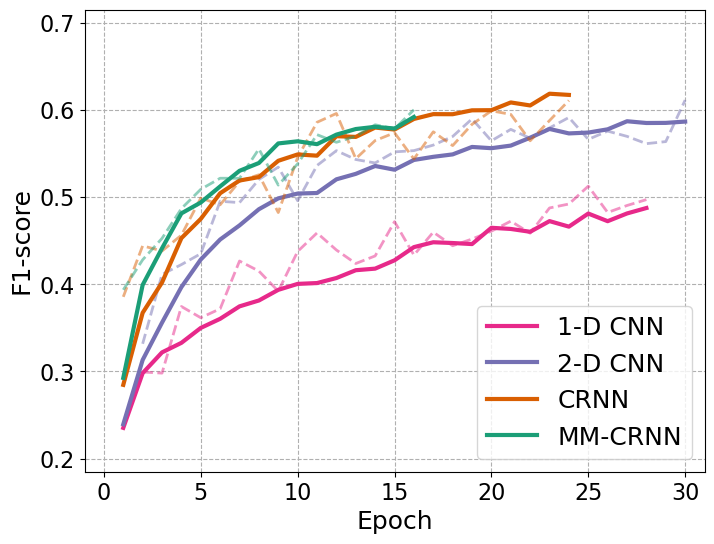

In [123]:
plot_macro_F1_score(['checkpoint_baseline1d.pt', 'checkpoint_baseline2d.pt', 'checkpoint_recurrent.pt', 'checkpoint_combinedrecurrent.pt'],
                    ['results_baseline1d.csv', 'results_baseline2d.csv', 'results_recurrent.csv', 'results_combinedrecurrent.csv'])